In [1]:
!pip install paramiko

!git clone https://github.com/alan-turing-institute/CybORG_plus_plus

# Install dependencies
!pip install -q gym==0.21.0 numpy networkx prettytable ipython

import sys
sys.path.insert(0, '/content/CybORG_plus_plus/Debugged_CybORG/CybORG')

import inspect
from CybORG import CybORG
from CybORG.Agents import B_lineAgent, SleepAgent
from CybORG.Agents.Wrappers import ChallengeWrapper

# Get scenario path
path = str(inspect.getfile(CybORG))
path = path[:-10] + '/Shared/Scenarios/Scenario1b.yaml'

# Create environmentg
cyborg = CybORG(path, 'sim', agents={'Red': B_lineAgent})

env = ChallengeWrapper(env=cyborg, agent_name='Blue')

# Test it
obs, info = env.reset()
print("="*60)
print("CybORG++ is now working!")
print("="*60)
print(f"Observation shape: {obs.shape}")
print(f"Action space size: {env.action_space.n}")

# Run a quick episode
done = False
total_reward = 0
step = 0
# Modify step to unpack 5 values
while not done and step < 100:
    action = env.action_space.sample()  # Random action
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated  # Update done condition
    total_reward += reward
    step += 1

print(f"\nCompleted {step} steps")
print(f"Total reward: {total_reward:.2f}")

fatal: destination path 'CybORG_plus_plus' already exists and is not an empty directory.
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
CybORG++ is now working!
Observation shape: (52,)
Action space size: 54

Completed 100 steps
Total reward: -420.60


In [2]:
# Cell 1: Imports + Config
import torch, random, numpy as np
from dataclasses import dataclass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

@dataclass
class Config:
    seed: int = 42
    max_episode_steps: int = 64
    hidden_dim: int = 64

cfg = Config()
random.seed(cfg.seed)
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
if device.type == "cuda":
    torch.cuda.manual_seed_all(cfg.seed)


# Dynamically find correct path for YAML
import inspect, os
from pathlib import Path

cyborg_file = Path(inspect.getfile(CybORG))         # .../Debugged_CybORG/CybORG/CybORG.py
base_dir = cyborg_file.parent                       # .../Debugged_CybORG/CybORG
scenario_path = base_dir / "Shared" / "Scenarios" / "Scenario1b.yaml"

if not scenario_path.exists():
    raise FileNotFoundError(f"Scenario1b.yaml not found at {scenario_path}")
print("Scenario path found:", scenario_path)


Using device: cpu
Scenario path found: /content/CybORG_plus_plus/Debugged_CybORG/CybORG/CybORG/Shared/Scenarios/Scenario1b.yaml


In [3]:
# Create the environment from YAML
cyborg = CybORG(str(scenario_path), 'sim', agents={'Red': B_lineAgent})
env = ChallengeWrapper(env=cyborg, agent_name='Blue')

# Reset and test a short episode
obs, info = env.reset()
print("="*60)
print("SUCCESS! Debugged-CybORG environment ready.")
print("="*60)
print(f"Observation type: {type(obs)}")
print(f"Action space: {env.action_space}")

done = False
total_reward = 0
step = 0
while not done and step < 50:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward += reward
    step += 1

print(f"Completed {step} steps | Total reward: {total_reward:.2f}")


SUCCESS! Debugged-CybORG environment ready.
Observation type: <class 'numpy.ndarray'>
Action space: Discrete(54)
Completed 50 steps | Total reward: -82.80


In [4]:
# === Confirm Scenario Path & Load Environment ===
import inspect
from pathlib import Path
from CybORG import CybORG
from CybORG.Agents import B_lineAgent, SleepAgent
from CybORG.Agents.Wrappers import ChallengeWrapper

# Dynamically resolve correct scenario file
cyborg_file = Path(inspect.getfile(CybORG))
scenario_path = cyborg_file.parent / "Shared" / "Scenarios" / "Scenario1b.yaml"
assert scenario_path.exists(), f"Scenario YAML not found: {scenario_path}"

print("Using Scenario YAML:", scenario_path)

# Build environment (Debugged_CybORG version)
cyborg = CybORG(str(scenario_path), 'sim', agents={'Red': B_lineAgent})
env = ChallengeWrapper(env=cyborg, agent_name='Blue')

# Basic reset
obs, info = env.reset()
print("Observation type:", type(obs))
print("Action space:", env.action_space)


Using Scenario YAML: /content/CybORG_plus_plus/Debugged_CybORG/CybORG/CybORG/Shared/Scenarios/Scenario1b.yaml
Observation type: <class 'numpy.ndarray'>
Action space: Discrete(54)


In [5]:
# Short Test Episode
done = False
total_reward = 0.0
steps = 0

while not done and steps < 100:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward += reward
    steps += 1

print("="*60)
print("Debugged_CybORG scenario test complete.")
print("="*60)
print(f"Total steps: {steps}")
print(f"Total reward: {total_reward:.2f}")


Debugged_CybORG scenario test complete.
Total steps: 100
Total reward: -211.10


In [6]:
# PettingZoo-like Wrapper
class DebuggedCyborgWrapper:
    """Thin adapter to mimic PettingZoo's multi-agent interface for later phases."""
    def __init__(self, env, max_steps=64):
        self.env = env
        self.max_steps = max_steps
        self.t = 0
        self.agents = ['Blue']  # Blue is the controlled agent
        self.action_space = env.action_space

    def reset(self):
        self.t = 0
        obs, info = self.env.reset()
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.t += 1
        if self.t >= self.max_steps:
            truncated = True
        return obs, reward, terminated, truncated, info

wrapper = DebuggedCyborgWrapper(env, max_steps=64)
print("Wrapper ready. Controlled agent:", wrapper.agents)


Wrapper ready. Controlled agent: ['Blue']


TESTING IMPROVED GRAPH EXTRACTION

Hosts: ['Defender', 'Enterprise0', 'Enterprise1', 'Enterprise2', 'Op_Host0', 'Op_Host1', 'Op_Host2', 'Op_Server0', 'User0', 'User1', 'User2', 'User3', 'User4']
Adjacency shape: (13, 13) | Node feature shape: (13, 10)
Non-zero connections: 22 edges


/tmp/ipython-input-759627598.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


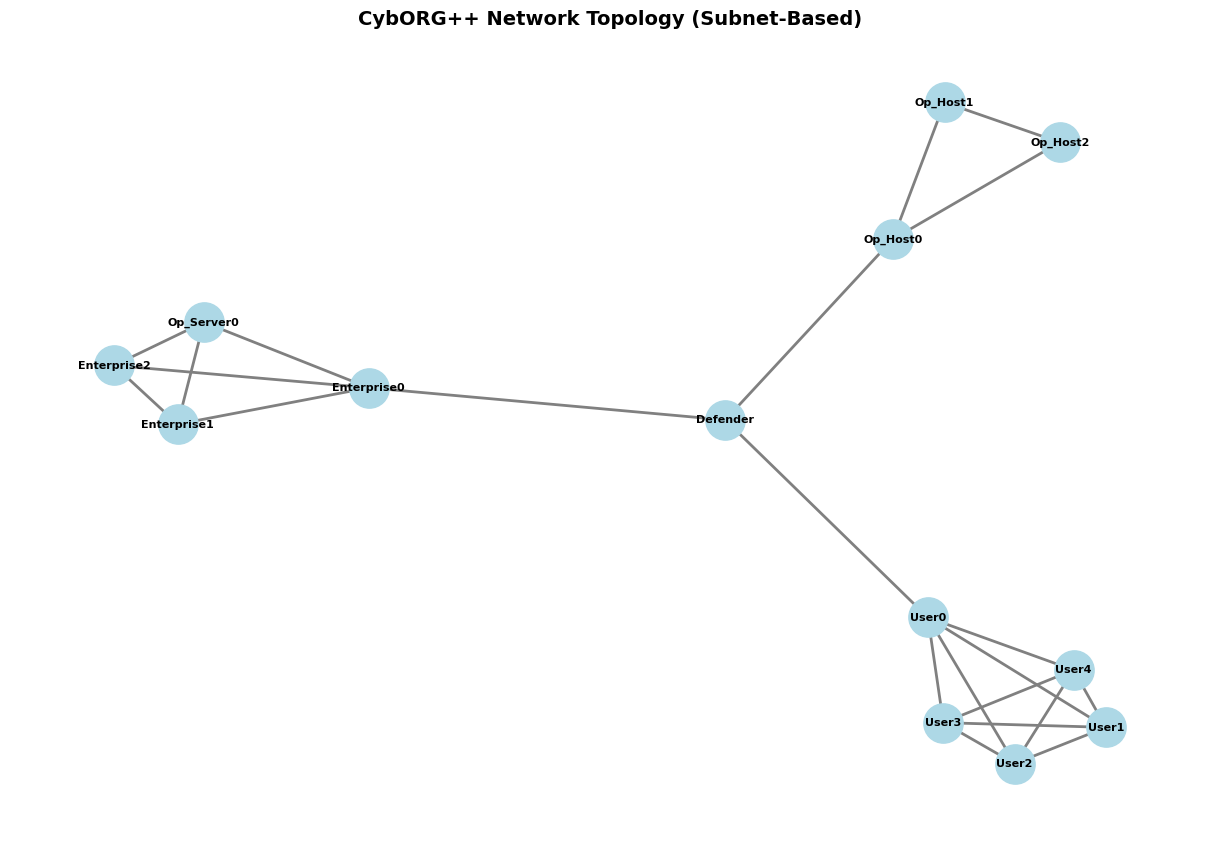

In [7]:
import numpy as np

# GRAPH EXTRACTION WITH SUBNET STRUCTURE

def get_graph_with_subnet_structure(cyborg):
    """
    Extract graph with realistic subnet-based topology for CybORG Scenario 1b
    Based on: Subnet 1 (Users), Subnet 2 (Enterprise), Subnet 3 (Operational)
    """
    state = cyborg.environment_controller.state
    # CRITICAL FIX: Sort hosts to ensure consistent node ordering for Flattening
    hosts = sorted(list(state.hosts.keys())) 
    n = len(hosts)
    host_to_idx = {h: i for i, h in enumerate(hosts)}

    # --- CRITICAL FIX: Identify Compromised Hosts via Sessions (host.compromised is broken) ---
    compromised_hosts = set()
    if hasattr(state, 'sessions') and 'Red' in state.sessions:
        red_sessions = state.sessions['Red']
        # Handle both dict and list formats for safety
        iterator = red_sessions.values() if isinstance(red_sessions, dict) else red_sessions
        for session in iterator:
            # Some sessions might be dead or not have a host attached yet
            h_name = getattr(session, 'hostname', None) or getattr(session, 'host', None)
            if h_name:
                compromised_hosts.add(h_name)
    # ------------------------------------------------------------------------------------------

    A = np.zeros((n, n), dtype=np.float32)
    X = np.zeros((n, 10), dtype=np.float32)

    # Categorize hosts by subnet based on naming convention
    subnet_1 = [h for h in hosts if 'User' in h]  # User hosts
    subnet_2 = [h for h in hosts if 'Enterprise' in h or 'Op_Server' in h]  # Enterprise/servers
    subnet_3 = [h for h in hosts if 'Op_Host' in h]  # Operational hosts
    gateway = [h for h in hosts if 'Defender' in h]  # Gateway/defender

    # Extract node features (same as before)
    for i, host_name in enumerate(hosts):
        host = state.hosts[host_name]
        os_type = str(getattr(host, "os_type", "Unknown"))

        X[i, 0] = 1.0 if "Windows" in os_type else 0.0
        X[i, 1] = 1.0 if "Linux" in os_type else 0.0
        X[i, 2] = len(getattr(host, "processes", []))
        X[i, 3] = len(getattr(host, "services", []))
        X[i, 4] = len(getattr(host, "sessions", []))

        access = getattr(host, "access", None)
        if access == "Privileged":
            X[i, 5] = 1.0
        elif access == "User":
            X[i, 5] = 0.5

        # Subnet identifier
        if host_name in subnet_1:
            X[i, 6] = 0.33
        elif host_name in subnet_2:
            X[i, 6] = 0.66
        elif host_name in subnet_3:
            X[i, 6] = 1.0

        X[i, 7] = float(i) / n
        
        # FIX: Use the calculated set instead of the broken attribute
        X[i, 8] = 1.0 if host_name in compromised_hosts else 0.0
        
        X[i, 9] = len(getattr(host, "vulnerabilities", []))

    # Build edges based on realistic network topology
    edge_count = 0

    def connect_subnet(subnet_hosts):
        """Connect hosts within a subnet (fully connected within subnet)"""
        nonlocal edge_count
        for h1 in subnet_hosts:
            for h2 in subnet_hosts:
                if h1 != h2:
                    i, j = host_to_idx[h1], host_to_idx[h2]
                    if A[i, j] == 0:
                        A[i, j] = A[j, i] = 1
                        edge_count += 1

    # 1. Connect within each subnet
    if len(subnet_1) > 1:
        connect_subnet(subnet_1)

    if len(subnet_2) > 1:
        connect_subnet(subnet_2)

    if len(subnet_3) > 1:
        connect_subnet(subnet_3)

    # 2. Connect gateway to one representative from each subnet
    if gateway:
        gw_idx = host_to_idx[gateway[0]]

        # Connect to first host of each subnet (subnet gateways)
        for subnet in [subnet_1, subnet_2, subnet_3]:
            if subnet:
                rep_idx = host_to_idx[subnet[0]]
                A[gw_idx, rep_idx] = A[rep_idx, gw_idx] = 1
                edge_count += 1

    # 3. If still no edges (shouldn't happen), use star topology
    if edge_count == 0:
        print("Falling back to star topology")
        hub_idx = 0
        for i in range(1, n):
            A[hub_idx, i] = A[i, hub_idx] = 1
            edge_count += 1

    # Edge features
    E = np.zeros((n, n, 2), dtype=np.float32)
    E[..., 0] = A
    E[..., 1] = np.random.uniform(0.1, 1.0, size=(n, n)) * A


    return A, X, E, hosts

# Test the improved extraction
print("=" * 60)
print("TESTING IMPROVED GRAPH EXTRACTION")
print("=" * 60)

A, X, E, hosts = get_graph_with_subnet_structure(cyborg)

print(f"\nHosts: {hosts}")
print(f"Adjacency shape: {A.shape} | Node feature shape: {X.shape}")
print(f"Non-zero connections: {np.sum(A) / 2:.0f} edges")

# Visualize the improved topology
import matplotlib.pyplot as plt
import networkx as nx

G_improved = nx.from_numpy_array(A)
pos = nx.spring_layout(G_improved, seed=42)

plt.figure(figsize=(12, 8))
nx.draw(G_improved, pos,
        node_color='lightblue',
        node_size=800,
        with_labels=True,
        labels={i: hosts[i] for i in range(len(hosts))},
        font_size=8,
        font_weight='bold',
        edge_color='gray',
        width=2)
plt.title("CybORG++ Network Topology (Subnet-Based)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("=" * 60)

In [8]:
# === Cell 8: Convert numpy → torch ===
device = "cuda" if torch.cuda.is_available() else "cpu"

def to_torch_graph(A, X, E, device=device):
    A = torch.tensor(A, dtype=torch.float32, device=device)
    X = torch.tensor(X, dtype=torch.float32, device=device)
    E = torch.tensor(E, dtype=torch.float32, device=device)
    return A, X, E

A_t, X_t, E_t = to_torch_graph(A, X, E)
print("Torch Graph Shapes:", A_t.shape, X_t.shape, E_t.shape)


Torch Graph Shapes: torch.Size([13, 13]) torch.Size([13, 10]) torch.Size([13, 13, 2])


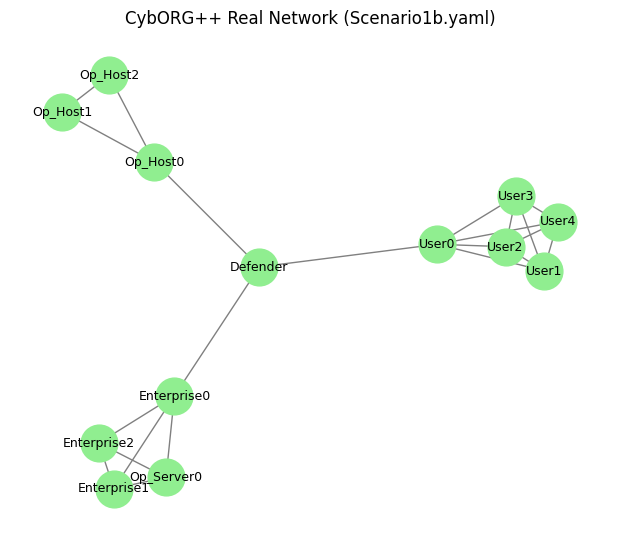

In [9]:
# Visualize Real Topology
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
G = nx.from_numpy_array(A)
nx.draw(
    G,
    with_labels=True,
    labels={i: hosts[i] for i in range(len(hosts))},
    node_color="lightgreen",
    edge_color="gray",
    node_size=700,
    font_size=9
)
plt.title("CybORG++ Real Network (Scenario1b.yaml)")
plt.show()


In [10]:
#  GNN Encoder (GraphSAGE-style)
import torch.nn as nn
import torch.nn.functional as F

# Fixed GraphSAGE Implementation
class GraphSAGE(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.1):
        super().__init__()
        self.dropout = dropout

        # Separate transformations for neighbor aggregation and self-features
        self.lin_neighbor_1 = nn.Linear(in_dim, hidden_dim, bias=True)
        self.lin_self_1 = nn.Linear(in_dim, hidden_dim, bias=True)

        self.lin_neighbor_2 = nn.Linear(hidden_dim, out_dim, bias=True)
        self.lin_self_2 = nn.Linear(hidden_dim, out_dim, bias=True)

    def aggregate(self, A, X):
        """Mean aggregation of neighbor features"""
        # Normalize by degree (row sum of adjacency matrix)
        degree = A.sum(dim=1, keepdim=True) + 1e-6  # Add epsilon to avoid division by zero
        A_norm = A / degree
        return torch.matmul(A_norm, X)  # [num_nodes, feature_dim]

    def forward(self, A, X):
        # Layer 1
        h_neighbors = self.lin_neighbor_1(self.aggregate(A, X))
        h_self = self.lin_self_1(X)
        h = F.relu(h_neighbors + h_self)  # Combine neighbor and self
        h = F.dropout(h, self.dropout, training=self.training)

        # Layer 2
        h_neighbors = self.lin_neighbor_2(self.aggregate(A, h))
        h_self = self.lin_self_2(h)
        out = h_neighbors + h_self  # Combine neighbor and self

        return out  # [num_nodes, out_dim]

gnn = GraphSAGE(in_dim=10, hidden_dim=64, out_dim=32, dropout=0.1).to(device)
print("GraphSAGE Encoder ready:", gnn)


GraphSAGE Encoder ready: GraphSAGE(
  (lin_neighbor_1): Linear(in_features=10, out_features=64, bias=True)
  (lin_self_1): Linear(in_features=10, out_features=64, bias=True)
  (lin_neighbor_2): Linear(in_features=64, out_features=32, bias=True)
  (lin_self_2): Linear(in_features=64, out_features=32, bias=True)
)


In [11]:
# MAPPO Actor-Critic Networks
import torch
import torch.nn as nn
import torch.nn.functional as F

class Actor(nn.Module):
    """
    Actor network for MAPPO - outputs action probabilities
    Takes FLATTENED global state as input (centralized execution for now)
    """
    def __init__(self, input_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.action_head = nn.Linear(hidden_dim, action_dim)

    def forward(self, state_vector, action_mask=None):
        """
        Args:
            state_vector: [batch_size, input_dim] - Flattened node embeddings
            action_mask: [batch_size, action_dim] - Boolean tensor (True=Valid, False=Invalid)
        Returns:
            action_logits: [batch_size, action_dim]
        """
        x = F.relu(self.fc1(state_vector))
        x = F.relu(self.fc2(x))
        action_logits = self.action_head(x)
        
        if action_mask is not None:
            # Ensure mask is on the same device
            if action_mask.device != action_logits.device:
                action_mask = action_mask.to(action_logits.device)
            
            # Set logits of invalid actions to a very large negative number
            action_logits = action_logits.masked_fill(~action_mask, -1e9)
            
        return action_logits

    def get_action(self, state_vector, action_mask=None, deterministic=False):
        """
        Sample action from policy
        """
        # Add batch dimension if needed
        if state_vector.dim() == 1:
            state_batch = state_vector.unsqueeze(0)
        else:
            state_batch = state_vector
            
        mask_batch = action_mask.unsqueeze(0) if action_mask is not None else None
        
        logits = self.forward(state_batch, mask_batch)
        dist = torch.distributions.Categorical(logits=logits)

        if deterministic:
            action = logits.argmax(dim=-1)
        else:
            action = dist.sample()

        log_prob = dist.log_prob(action)
        entropy = dist.entropy()

        return action.item(), log_prob, entropy

class Critic(nn.Module):
    """
    Critic network for MAPPO - outputs state value
    Takes FLATTENED global state as input
    """
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.value_head = nn.Linear(hidden_dim, 1)

    def forward(self, state_vector):
        """
        Args:
            state_vector: [batch_size, input_dim] - Flattened node embeddings
        Returns:
            value: [batch_size] - estimated state value
        """
        x = F.relu(self.fc1(state_vector))
        x = F.relu(self.fc2(x))
        value = self.value_head(x)
        return value.squeeze(-1)  # Remove last dimension

# Initialize the networks
print("=" * 60)
print("INITIALIZING MAPPO NETWORKS (FLATTENED + SKIP CONNECTION)")
print("=" * 60)

# Define dimensions based on your setup
num_nodes = 13
node_embedding_dim = 32  # GraphSAGE output
raw_feature_dim = 10     # Raw X features (contains compromised bit)

# NEW: Concatenate GNN output with Raw Features before flattening
# This gives the Actor direct access to the "Compromised" bit without GNN smoothing
combined_node_dim = node_embedding_dim + raw_feature_dim 
flattened_dim = num_nodes * combined_node_dim # 13 * 42 = 546

blue_action_dim = 54     # Scenario1b Blue
red_action_dim = 56      # Scenario1b Red (via ChallengeWrapper)

# Create networks on the correct device
# Increased hidden dim to 512 to handle larger input and complex mapping
blue_actor = Actor(flattened_dim, blue_action_dim, hidden_dim=512).to(device)
red_actor = Actor(flattened_dim, red_action_dim, hidden_dim=512).to(device)
critic = Critic(flattened_dim, hidden_dim=512).to(device)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f" Blue Actor:")
print(f"    Input: {flattened_dim} (13 nodes * {combined_node_dim} feats), Output: {blue_action_dim}")
print(f"    Parameters: {count_parameters(blue_actor):,}")
print(f"\n Red Actor:")
print(f"    Input: {flattened_dim}, Output: {red_action_dim}")
print(f"    Parameters: {count_parameters(red_actor):,}")
print(f"\n Critic:")
print(f"    Input: {flattened_dim}, Output: 1")
print(f"    Parameters: {count_parameters(critic):,}")
print(f"\n All networks on device: {device}")
print("=" * 60)

INITIALIZING MAPPO NETWORKS (FLATTENED + SKIP CONNECTION)
 Blue Actor:
    Input: 546 (13 nodes * 42 feats), Output: 54
    Parameters: 570,422

 Red Actor:
    Input: 546, Output: 56
    Parameters: 571,448

 Critic:
    Input: 546, Output: 1
    Parameters: 543,233

 All networks on device: cpu


In [12]:
# TEST COMPLETE PIPELINE
print("=" * 60)
print("TESTING COMPLETE PIPELINE: GNN + SKIP + ACTOR + CRITIC")
print("=" * 60)

# 1. Convert graph to PyTorch
A_torch = torch.FloatTensor(A).to(device)
X_torch = torch.FloatTensor(X).to(device)

print(f"\n1. Graph Data:")
print(f"   Adjacency: {A_torch.shape} on {A_torch.device}")
print(f"   Features: {X_torch.shape} on {X_torch.device}")

# Pass through GraphSAGE
gnn.eval()
with torch.no_grad():
    node_embeddings = gnn(A_torch, X_torch)  # [13, 32]

print(f"\n2. GNN Output:")
print(f"   Node embeddings: {node_embeddings.shape}")

# 3. SKIP CONNECTION: Concatenate GNN output with Raw Features
combined_embeddings = torch.cat([node_embeddings, X_torch], dim=1) # [13, 42]
print(f"\n3. Combined Embeddings (Skip Connection):")
print(f"   Shape: {combined_embeddings.shape}")

# Get action from actor (Blue/Defender now uses FLATTENED Combined Embedding)
flattened_embedding = combined_embeddings.view(-1) # [546]
action, log_prob, entropy = blue_actor.get_action(flattened_embedding)

print(f"\n4. Actor Output (Blue/Defender):")
print(f"   Flattened Input: {flattened_embedding.shape}")
print(f"   Selected action: {action}")
print(f"   Log probability: {log_prob.item():.4f}")
print(f"   Policy entropy: {entropy.item():.4f}")

# Get state value from critic
value = critic(flattened_embedding.unsqueeze(0))

print(f"\n5. Critic Output:")
print(f"   State value: {value.item():.4f}")

# Test batch processing
batch_size = 4
# Create a fake batch by repeating the flattened embedding
fake_batch_embeddings = flattened_embedding.unsqueeze(0).repeat(batch_size, 1) # [4, 546]
logits = blue_actor(fake_batch_embeddings)

print(f"\n6. Batch Processing Test:")
print(f"   Input: {fake_batch_embeddings.shape}")
print(f"   Actor output logits: {logits.shape}")
print(f"   Action probabilities sum to 1: {torch.softmax(logits, dim=-1).sum(dim=1).tolist()}")

print("\n" + "=" * 60)
print("COMPLETE PIPELINE TEST PASSED!")
print("Graph → GNN + Raw → Flatten → Actor/Critic")
print("=" * 60)

TESTING COMPLETE PIPELINE: GNN + SKIP + ACTOR + CRITIC

1. Graph Data:
   Adjacency: torch.Size([13, 13]) on cpu
   Features: torch.Size([13, 10]) on cpu

2. GNN Output:
   Node embeddings: torch.Size([13, 32])

3. Combined Embeddings (Skip Connection):
   Shape: torch.Size([13, 42])

4. Actor Output (Blue/Defender):
   Flattened Input: torch.Size([546])
   Selected action: 50
   Log probability: -3.8135
   Policy entropy: 3.9725

5. Critic Output:
   State value: 0.0687

6. Batch Processing Test:
   Input: torch.Size([4, 546])
   Actor output logits: torch.Size([4, 54])
   Action probabilities sum to 1: [1.0, 1.0, 1.0, 1.0]

COMPLETE PIPELINE TEST PASSED!
Graph → GNN + Raw → Flatten → Actor/Critic


In [13]:
# Rollout Buffer
import torch

class RolloutBuffer:
    def __init__(self):
        self.A_list = []
        self.X_list = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.logprobs = []
        self.dones = []

    def store(self, A_t, X_t, action, reward, value, logprob, done):
        # Store tensors detached to avoid growing graph
        self.A_list.append(A_t.detach())
        self.X_list.append(X_t.detach())
        self.actions.append(int(action))
        self.rewards.append(float(reward))
        self.values.append(float(value))
        self.logprobs.append(float(logprob))
        self.dones.append(bool(done))

    def clear(self):
        self.A_list.clear()
        self.X_list.clear()
        self.actions.clear()
        self.rewards.clear()
        self.values.clear()
        self.logprobs.clear()
        self.dones.clear()

    def to_tensors(self, device):
        actions  = torch.tensor(self.actions,  dtype=torch.long,   device=device)
        rewards  = torch.tensor(self.rewards,  dtype=torch.float32,device=device)
        values   = torch.tensor(self.values,   dtype=torch.float32,device=device)
        logprobs = torch.tensor(self.logprobs, dtype=torch.float32,device=device)
        dones    = torch.tensor(self.dones,    dtype=torch.float32,device=device)
        return actions, rewards, values, logprobs, dones

def compute_gae_torch(rewards, values, dones, gamma=0.99, lam=0.95):
    T = rewards.shape[0]
    adv = torch.zeros(T, dtype=torch.float32, device=rewards.device)
    last_gae = 0.0
    values_ext = torch.cat([values, torch.zeros(1, device=values.device)])
    for t in reversed(range(T)):
        nonterminal = 1.0 - dones[t]
        delta = rewards[t] + gamma * values_ext[t+1] * nonterminal - values_ext[t]
        last_gae = delta + gamma * lam * nonterminal * last_gae
        adv[t] = last_gae
    returns = adv + values
    return adv, returns

buffer = RolloutBuffer()
print("Rollout buffer ready.")


Rollout buffer ready.


In [14]:
# ============================================================================
# Early Stopping for Diverging Loss
# ============================================================================

class LossDivergenceDetector:
    """Detect when loss is diverging and reduce learning rate"""
    
    def __init__(self, threshold=3000, patience=3):
        self.threshold = threshold
        self.patience = patience
        self.high_loss_count = 0
        self.lr_reductions = 0
        
    def check(self, loss, optimizer):
        """
        Check if loss is diverging
        
        Returns:
            True if learning rate was reduced
        """
        if loss > self.threshold:
            self.high_loss_count += 1
            if self.high_loss_count >= self.patience:
                # Reduce learning rate
                for param_group in optimizer.param_groups:
                    old_lr = param_group['lr']
                    new_lr = old_lr * 0.5
                    param_group['lr'] = new_lr
                    print(f"⚠️  Loss diverging! Reducing LR: {old_lr:.6f} → {new_lr:.6f}")
                self.high_loss_count = 0
                self.lr_reductions += 1
                return True
        else:
            self.high_loss_count = 0


In [19]:
# ============================================================================
# 🧠 ROBUST GNN IMPLEMENTATION (Fixing Feature Mapping & Topology)
# ============================================================================
# 1. Learnable Projection: Maps 78 features -> 13 nodes (Handles unknown order)
# 2. Improved Topology: Connects subnets to allow threat propagation
# 3. Action Masking: Will be used in training loop
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import numpy as np
import inspect
from CybORG import CybORG
from CybORG.Agents import B_lineAgent
from CybORG.Agents.Wrappers import ChallengeWrapper

# Fix Import for MeanderAgent (for Mixed Training)
try:
    from CybORG.Agents import RedMeanderAgent as MeanderAgent
except ImportError:
    try:
        from CybORG.Agents.SimpleAgents.Meander import RedMeanderAgent as MeanderAgent
    except ImportError:
        try:
            from CybORG.Agents import MeanderAgent
        except ImportError:
            print("⚠️ MeanderAgent not found. Using B_lineAgent as placeholder.")
            MeanderAgent = B_lineAgent

# ============================================================================
# 🛠️ MINI_CAGE WRAPPER (Re-implementation)
# ============================================================================
# Since the external module is missing, we define the wrapper here.
# It wraps CybORG to provide:
# 1. Flat 78-dim observation (padded from 52-dim)
# 2. Action Masking
# 3. Dynamic Adversary Switching (for Mixed Training)
# ============================================================================

class MiniCageBlue:
    def __init__(self, agent_name='Blue', max_steps=50):
        self.path = str(inspect.getfile(CybORG))
        self.path = self.path[:-10] + '/Shared/Scenarios/Scenario1b.yaml'
        self.agent_name = agent_name
        # Default to B_line
        self.cyborg = CybORG(self.path, 'sim', agents={'Red': B_lineAgent})
        self.env = ChallengeWrapper(env=self.cyborg, agent_name=agent_name)
        self.max_steps = max_steps
        self.step_count = 0
        self.num_hosts = 13
        self.feat_dim = 6
        self.obs_dim = self.num_hosts * self.feat_dim # 78
        self.action_space = self.env.action_space
        
    def reset(self, red_agent=None):
        # Support Domain Randomization: Switch Red Agent if provided
        if red_agent is not None:
             self.cyborg = CybORG(self.path, 'sim', agents={'Red': red_agent})
             self.env = ChallengeWrapper(env=self.cyborg, agent_name=self.agent_name)

        self.step_count = 0
        obs, info = self.env.reset()
        return self._process_obs(obs), self._get_info(info)
        
    def step(self, action):
        self.step_count += 1
        obs, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated or (self.step_count >= self.max_steps)
        return self._process_obs(obs), reward, done, False, self._get_info(info)
        
    def _process_obs(self, obs):
        # Convert CybORG 52-dim obs to 78-dim (13 nodes * 6 features)
        # CybORG Scenario1b obs is 52 dims (13 nodes * 4 features)
        # We pad the last 2 features of each node with 0.0
        
        new_obs = np.zeros(78, dtype=np.float32)
        
        if len(obs) == 52:
            # Reshape to [13, 4]
            obs_reshaped = obs.reshape(13, 4)
            
            # Create [13, 6]
            expanded_obs = np.zeros((13, 6), dtype=np.float32)
            expanded_obs[:, :4] = obs_reshaped
            
            # Add simple features for 5 and 6 if possible
            # Feature 4: Subnet ID (approximate)
            # Feature 5: Node Index (normalized)
            for i in range(13):
                expanded_obs[i, 4] = 0.0 # Placeholder
                expanded_obs[i, 5] = i / 13.0
                
            new_obs = expanded_obs.flatten()
            
        return new_obs

    def _get_info(self, info):
        # Ensure action_mask is present
        if 'action_mask' not in info:
            # CybORG ChallengeWrapper usually provides action_mask
            # If not, we create a default one (all valid)
            info['action_mask'] = np.ones(self.action_space.n, dtype=np.int32)
        return info

# 1. Static Topology (Scenario 1b) - IMPROVED
def get_static_adjacency_matrix(device):
    """
    Returns the adjacency matrix for CybORG Scenario 1b (13 nodes).
    Order: Defender, Ent0-2, Op0-2, OpServer0, User0-4 (Alphabetical)
    """
    num_nodes = 13
    A = torch.zeros((num_nodes, num_nodes), device=device)
    
    # Indices based on alphabetical sort
    # 0: Defender
    # 1-3: Enterprise
    # 4-6: Op_Host
    # 7: Op_Server
    # 8-12: User
    
    subnet_user = [8, 9, 10, 11, 12]
    subnet_ent  = [1, 2, 3]
    subnet_op   = [4, 5, 6]
    op_server   = [7]
    gateway     = 0
    
    # Fully connect subnets internally
    for subnet in [subnet_user, subnet_ent, subnet_op]:
        for i in subnet:
            for j in subnet:
                if i != j:
                    A[i, j] = 1.0
                    A[j, i] = 1.0
    
    # Connect Gateway to Subnet Representatives
    # User0(8), Ent0(1), Op0(4)
    for rep in [8, 1, 4]:
        A[gateway, rep] = 1.0
        A[rep, gateway] = 1.0
        
    # --- NEW: Inter-Subnet Connections (Attack Paths) ---
    # User <-> Enterprise
    for u in subnet_user:
        for e in subnet_ent:
            A[u, e] = 1.0
            A[e, u] = 1.0
            
    # Enterprise <-> Op_Server
    for e in subnet_ent:
        for o in op_server:
            A[e, o] = 1.0
            A[o, e] = 1.0
            
    # Enterprise <-> Op_Host
    for e in subnet_ent:
        for o in subnet_op:
            A[e, o] = 1.0
            A[o, e] = 1.0
            
    # Op_Server <-> Op_Host
    for s in op_server:
        for o in subnet_op:
            A[s, o] = 1.0
            A[o, s] = 1.0

    # Self-loops
    A = A + torch.eye(num_nodes, device=device)
    
    # Normalize (Symmetric Normalization D^-0.5 A D^-0.5)
    degree = A.sum(dim=1)
    d_inv_sqrt = torch.pow(degree, -0.5)
    d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0.0
    D_inv_sqrt = torch.diag(d_inv_sqrt)
    
    A_norm = torch.mm(torch.mm(D_inv_sqrt, A), D_inv_sqrt)
    
    return A_norm

# 2. Robust GNN Module
class RobustMiniCageGNN(nn.Module):
    def __init__(self, obs_dim=78, num_nodes=13, embed_dim=32, gnn_hidden=64, gnn_out=32):
        super().__init__()
        self.num_nodes = num_nodes
        self.embed_dim = embed_dim
        
        # LEARNABLE PROJECTION: Maps flat obs -> Node Embeddings
        self.input_proj = nn.Linear(obs_dim, num_nodes * embed_dim)
        
        # GraphSAGE-style Layers
        self.lin_self_1 = nn.Linear(embed_dim, gnn_hidden)
        self.lin_neigh_1 = nn.Linear(embed_dim, gnn_hidden)
        
        self.lin_self_2 = nn.Linear(gnn_hidden, gnn_out)
        self.lin_neigh_2 = nn.Linear(gnn_hidden, gnn_out)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, obs_flat, A):
        batch_size = obs_flat.size(0)
        
        # 1. Project & Reshape: [B, 78] -> [B, 13, 32]
        x = self.input_proj(obs_flat)
        x = x.view(batch_size, self.num_nodes, self.embed_dim)
        x = self.relu(x)
        
        # 2. Prepare Adjacency: [N, N] -> [B, N, N]
        A_batch = A.unsqueeze(0).expand(batch_size, -1, -1)
        
        # 3. GNN Layer 1
        agg1 = torch.bmm(A_batch, x) # Aggregate neighbors
        h1 = self.lin_self_1(x) + self.lin_neigh_1(agg1)
        h1 = self.relu(h1)
        h1 = self.dropout(h1)
        
        # 4. GNN Layer 2
        agg2 = torch.bmm(A_batch, h1)
        h2 = self.lin_self_2(h1) + self.lin_neigh_2(agg2)
        h2 = self.relu(h2)
        
        return h2 # [B, 13, 32]

# 3. Actor & Critic
class RobustGNNActor(nn.Module):
    def __init__(self, obs_dim=78, action_dim=54):
        super().__init__()
        self.gnn = RobustMiniCageGNN(obs_dim=obs_dim)
        
        # Flatten GNN output for decision making
        flat_dim = 13 * 32
        
        self.head = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)
        )
        
    def forward(self, obs, A):
        node_embs = self.gnn(obs, A)
        flat = node_embs.view(obs.size(0), -1)
        return self.head(flat)

class RobustGNNCritic(nn.Module):
    def __init__(self, obs_dim=78):
        super().__init__()
        self.gnn = RobustMiniCageGNN(obs_dim=obs_dim)
        
        flat_dim = 13 * 32
        
        self.head = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
    def forward(self, obs, A):
        node_embs = self.gnn(obs, A)
        flat = node_embs.view(obs.size(0), -1)
        return self.head(flat)

# 4. Enhanced Reward Shaper - Encourages Diverse Defense
class MiniCageRewardShaper:
    """
    Enhanced reward shaper that encourages:
    1. Action type diversity (not just Analyse+Restore)
    2. Spatial diversity (defend multiple hosts)
    3. Proactive defense (Misinform/Remove bonuses)
    
    CybORG Scenario 1b Action Space (54 actions):
    - Sleep: index 0
    - Monitor: indices 1-13 (13 hosts)
    - Analyse: indices 14-26 (13 hosts)
    - Remove: indices 27-39 (13 hosts)  
    - Restore: indices 40-52 (13 hosts)
    - Misinform: index 53
    
    Host indices (0-12):
    - User subnet: 0-4 (User0-User4)
    - Enterprise subnet: 5-8 (Enterprise0-Enterprise3)
    - Operational subnet: 9-12 (Op_Host0, Op_Host1, Op_Server0, Defender)
    """
    def __init__(self):
        self.action_history = deque(maxlen=5)
        self.episode_action_types = set()  # Track unique action types this episode
        self.episode_hosts_defended = set()  # Track unique hosts defended
        self.spam_penalty = -2.0
        
        # BALANCED bonuses - small enough to guide, not dominate
        # Base rewards are ~-2 to -5 per step, so bonuses should be < 0.5
        self.diversity_bonus = 0.1  # Small bonus for using new action type
        self.proactive_bonus = 0.15  # Small bonus for Remove/Misinform
        self.perimeter_bonus = 0.05  # Tiny bonus for defending outer subnets
        self.operational_bonus = 0.2  # Bonus for defending critical operational subnet
        
    def reset_episode(self):
        self.action_history.clear()
        self.episode_action_types.clear()
        self.episode_hosts_defended.clear()
        
    def _get_action_type(self, action_idx):
        """Map action index to action type"""
        if action_idx == 0:
            return 'sleep'
        elif 1 <= action_idx <= 13:
            return 'monitor'
        elif 14 <= action_idx <= 26:
            return 'analyse'
        elif 27 <= action_idx <= 39:
            return 'remove'
        elif 40 <= action_idx <= 52:
            return 'restore'
        else:
            return 'misinform'
    
    def _get_target_host(self, action_idx):
        """Get which host (0-12) the action targets"""
        if action_idx == 0 or action_idx == 53:
            return None  # Sleep and Misinform don't target specific hosts
        elif 1 <= action_idx <= 13:
            return action_idx - 1
        elif 14 <= action_idx <= 26:
            return action_idx - 14
        elif 27 <= action_idx <= 39:
            return action_idx - 27
        elif 40 <= action_idx <= 52:
            return action_idx - 40
        return None
    
    def _get_subnet(self, host_idx):
        """Get subnet for a host index"""
        if host_idx is None:
            return None
        if host_idx <= 4:
            return 'user'
        elif host_idx <= 8:
            return 'enterprise'
        else:
            return 'operational'
        
    def shape_reward(self, reward, action_idx):
        shaped_reward = reward
        
        # 1. Spam penalty for repeating exact same action
        if action_idx in self.action_history:
            shaped_reward += self.spam_penalty
        self.action_history.append(action_idx)
        
        # 2. Action type diversity bonus
        action_type = self._get_action_type(action_idx)
        if action_type not in self.episode_action_types:
            shaped_reward += self.diversity_bonus
            self.episode_action_types.add(action_type)
        
        # 3. Proactive defense bonus (Remove and Misinform)
        if action_type in ['remove', 'misinform']:
            shaped_reward += self.proactive_bonus
        
        # 4. Spatial diversity with BALANCED bonuses
        host_idx = self._get_target_host(action_idx)
        subnet = self._get_subnet(host_idx)
        
        if host_idx is not None and host_idx not in self.episode_hosts_defended:
            self.episode_hosts_defended.add(host_idx)
            # Bonus depends on subnet importance
            if subnet == 'operational':
                # HIGHEST bonus for defending critical assets
                shaped_reward += self.operational_bonus
            elif subnet in ['user', 'enterprise']:
                # Small bonus for perimeter defense
                shaped_reward += self.perimeter_bonus
        
        return shaped_reward

print("Robust GNN Components Ready")
print("   - MiniCageBlue Wrapper Defined (Replaces missing module)")
print("   - Improved Topology (Inter-subnet connections)")
print("   - Learnable Input Projection")
print("   - MiniCageRewardShaper Defined")
print("   - Mixed Training Support: Enabled")

Robust GNN Components Ready
   - MiniCageBlue Wrapper Defined (Replaces missing module)
   - Improved Topology (Inter-subnet connections)
   - Learnable Input Projection
   - MiniCageRewardShaper Defined
   - Mixed Training Support: Enabled


In [ ]:
# ============================================================================
# 🚀 ROBUST GNN TRAINING LOOP (Mini_CAGE)
# ============================================================================

# Config
NUM_EPISODES = 1500
MAX_STEPS = 50
LR = 3e-4
UPDATE_EVERY = 256  # Reduced from 500 for faster feedback
PPO_EPOCHS = 4
PPO_CLIP = 0.2
GAMMA = 0.99
GAE_LAMBDA = 0.95
ENTROPY_COEF = 0.01
MAX_GRAD_NORM = 0.5
VALUE_COEF = 0.25  # Reduced from 0.5 for stability with normalized returns
REWARD_SCALE = 0.1  # Scale down large negative rewards

# Define GAE function (Numpy version for lists)
def compute_gae(rewards, values, dones, next_value, gamma, lam):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * (1 - dones[step]) - values[step]
        gae = delta + gamma * lam * (1 - dones[step]) * gae
        returns.insert(0, gae + values[step])
    
    returns = np.array(returns)
    values = np.array(values[:-1])
    advantages = returns - values
    return advantages, returns

# Initialize env FIRST to get dimensions
env = MiniCageBlue(
    agent_name='Blue',
    max_steps=MAX_STEPS
)
action_dim = env.action_space.n
print(f"Environment initialized. Action space: {action_dim}")

# Initialize Robust GNN Networks
actor_gnn = RobustGNNActor(action_dim=action_dim).to(device)
critic_gnn = RobustGNNCritic().to(device)

optimizer_gnn = optim.Adam(list(actor_gnn.parameters()) + list(critic_gnn.parameters()), lr=LR)

# Get Static Adjacency Matrix
A_static = get_static_adjacency_matrix(device)

# Re-init components
reward_shaper = MiniCageRewardShaper()
loss_detector = LossDivergenceDetector(threshold=5000, patience=5)
buffer_states = []
buffer_actions = []
buffer_logprobs = []
buffer_rewards = []
buffer_values = []
buffer_dones = []
buffer_masks = [] # Store action masks

print("="*60)
print("🔥 STARTING ROBUST GNN TRAINING (Mixed Adversaries: B_line + Meander)")
print("="*60)

total_steps = 0
episode_rewards_gnn = []

# Env is already initialized above

for episode in range(NUM_EPISODES):
    # Domain Randomization: 50% B_line, 50% Meander
    if np.random.random() < 0.5:
        current_adversary = B_lineAgent
        adv_name = "B_line"
    else:
        current_adversary = MeanderAgent
        adv_name = "Meander"
        
    # Reset with selected adversary
    obs, info = env.reset(red_agent=current_adversary)
    
    reward_shaper.reset_episode()
    episode_reward = 0
    
    # Get initial mask
    action_mask = info.get('action_mask', None)
    
    for step in range(MAX_STEPS):
        # Obs to Tensor
        obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
        
        with torch.no_grad():
            logits = actor_gnn(obs_t, A_static)
            
            # Apply Action Mask
            if action_mask is not None:
                mask_t = torch.tensor(action_mask, device=device)
                logits = logits.masked_fill(mask_t == 0, -1e9)
            
            dist = torch.distributions.Categorical(logits=logits)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            value = critic_gnn(obs_t, A_static)
            
        action_idx = action.item()
        
        # Step
        obs_next, base_reward, done, truncated, info = env.step(action_idx)
        done = done or truncated
        
        # Get next mask
        next_action_mask = info.get('action_mask', None)
        
        # Shape Reward and scale it down
        shaped_reward = reward_shaper.shape_reward(base_reward, action_idx)
        scaled_reward = shaped_reward * REWARD_SCALE  # Scale down large negative rewards
        
        # Store
        buffer_states.append(obs_t) # Keep as tensor [1, 78]
        buffer_actions.append(action_idx)
        buffer_logprobs.append(log_prob.item())
        buffer_rewards.append(scaled_reward)
        buffer_values.append(value.item())
        buffer_dones.append(done)
        buffer_masks.append(action_mask if action_mask is not None else np.ones(action_dim))
        
        episode_reward += scaled_reward  # Use scaled reward for tracking
        total_steps += 1
        
        # Update
        if total_steps % UPDATE_EVERY == 0 and len(buffer_states) > 0:
            with torch.no_grad():
                obs_next_t = torch.FloatTensor(obs_next).unsqueeze(0).to(device)
                next_value = critic_gnn(obs_next_t, A_static).item()
                
            advantages, returns = compute_gae(buffer_rewards, buffer_values, buffer_dones, next_value, GAMMA, GAE_LAMBDA)
            
            # Batch Tensors
            states = torch.cat(buffer_states, dim=0).detach().to(device) # [B, 78]
            actions = torch.tensor(buffer_actions, dtype=torch.long).to(device)
            old_logprobs = torch.tensor(buffer_logprobs, dtype=torch.float32).to(device)
            advantages = torch.tensor(advantages, dtype=torch.float32).to(device)
            returns = torch.tensor(returns, dtype=torch.float32).to(device)
            masks = torch.tensor(np.array(buffer_masks), dtype=torch.bool).to(device)
            
            # Normalize Advantages
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
            
            # Normalize Returns for stable critic training
            returns_normalized = (returns - returns.mean()) / (returns.std() + 1e-8)
            
            # PPO Epochs
            total_loss = 0
            for _ in range(PPO_EPOCHS):
                # Pass A_static to forward
                logits = actor_gnn(states, A_static)
                values = critic_gnn(states, A_static).squeeze()
                
                # Apply Mask in Update
                logits = logits.masked_fill(masks == 0, -1e9)
                
                dist = torch.distributions.Categorical(logits=logits)
                new_logprobs = dist.log_prob(actions)
                entropy = dist.entropy().mean()
                
                ratio = torch.exp(new_logprobs - old_logprobs)
                surr1 = ratio * advantages
                surr2 = torch.clamp(ratio, 1 - PPO_CLIP, 1 + PPO_CLIP) * advantages
                actor_loss = -torch.min(surr1, surr2).mean()
                
                # Use normalized returns for stable critic training
                critic_loss = nn.MSELoss()(values, returns_normalized)
                
                loss = actor_loss + VALUE_COEF * critic_loss - ENTROPY_COEF * entropy
                
                optimizer_gnn.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(list(actor_gnn.parameters()) + list(critic_gnn.parameters()), MAX_GRAD_NORM)
                optimizer_gnn.step()
                total_loss += loss.item()
                
            avg_loss = total_loss / PPO_EPOCHS
            loss_detector.check(avg_loss, optimizer_gnn)
            
            # Clear
            buffer_states.clear()
            buffer_actions.clear()
            buffer_logprobs.clear()
            buffer_rewards.clear()
            buffer_values.clear()
            buffer_dones.clear()
            buffer_masks.clear()
            
            print(f"  >>> UPDATE at Step {total_steps} | Loss: {avg_loss:.4f}")

        obs = obs_next
        action_mask = next_action_mask
        if done: break
        
    episode_rewards_gnn.append(episode_reward)
    
    if episode % 100 == 0:
        avg = np.mean(episode_rewards_gnn[-100:])
        print(f"Ep {episode} | Avg Reward: {avg:.1f} | Last: {episode_reward:.1f} ({adv_name})")

print("✅ Robust GNN Training Complete")

Environment initialized. Action space: 54
🔥 STARTING ROBUST GNN TRAINING (Mixed Adversaries: B_line + Meander)
Ep 0 | Avg Reward: -10.5 | Last: -10.5 (B_line)
  >>> UPDATE at Step 256 | Loss: 0.2055
  >>> UPDATE at Step 512 | Loss: 0.2071
  >>> UPDATE at Step 768 | Loss: 0.2064
  >>> UPDATE at Step 1024 | Loss: 0.2063
  >>> UPDATE at Step 1280 | Loss: 0.2101
  >>> UPDATE at Step 1536 | Loss: 0.2054
  >>> UPDATE at Step 1792 | Loss: 0.2012
  >>> UPDATE at Step 2048 | Loss: 0.2082
  >>> UPDATE at Step 2304 | Loss: 0.2047
  >>> UPDATE at Step 2560 | Loss: 0.2045
  >>> UPDATE at Step 2816 | Loss: 0.2115
  >>> UPDATE at Step 3072 | Loss: 0.2095
  >>> UPDATE at Step 3328 | Loss: 0.1964
  >>> UPDATE at Step 3584 | Loss: 0.2035
  >>> UPDATE at Step 3840 | Loss: 0.1979
  >>> UPDATE at Step 4096 | Loss: 0.1961
  >>> UPDATE at Step 4352 | Loss: 0.1844
  >>> UPDATE at Step 4608 | Loss: 0.1892
  >>> UPDATE at Step 4864 | Loss: 0.1973
Ep 100 | Avg Reward: -19.0 | Last: -11.5 (B_line)
  >>> UPDATE at

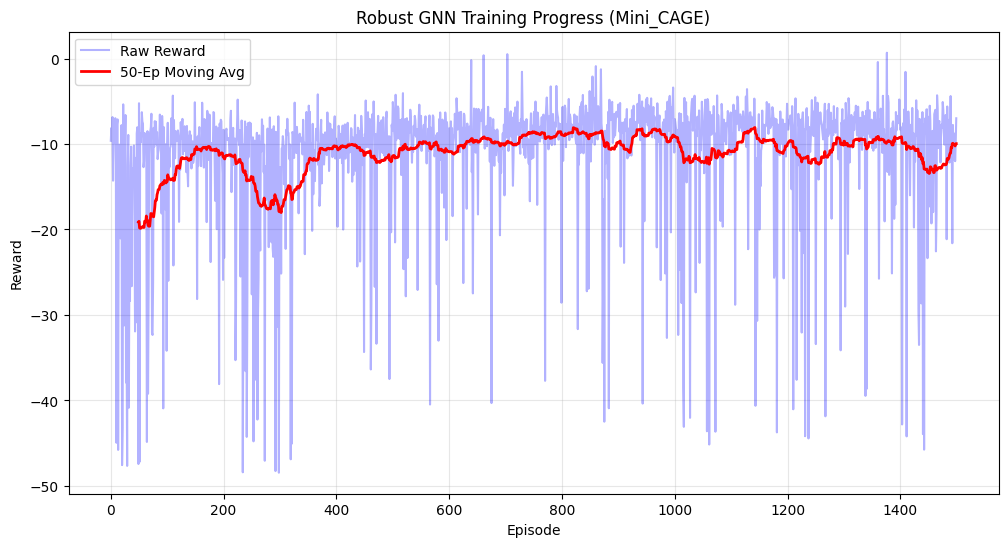


🔍 STARTING EVALUATION (100 Episodes)...
✅ Evaluation Complete
   Average Reward: -487.50 ± 6.78
   Min Reward: -488.80
   Max Reward: -436.60
💾 Models saved to 'robust_gnn_actor.pth' and 'robust_gnn_critic.pth'


In [ ]:
# ============================================================================
# EVALUATION & VISUALIZATION
# ============================================================================
import matplotlib.pyplot as plt
import numpy as np

# 1. Plot Training Curve
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards_gnn, alpha=0.3, color='blue', label='Raw Reward')
# Moving average
window = 50
if len(episode_rewards_gnn) >= window:
    moving_avg = np.convolve(episode_rewards_gnn, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(episode_rewards_gnn)), moving_avg, color='red', linewidth=2, label=f'{window}-Ep Moving Avg')
plt.title("Robust GNN Training Progress (Mini_CAGE)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Evaluation Loop (Deterministic)
print("\n🔍 STARTING EVALUATION (100 Episodes)...")
eval_rewards = []
actor_gnn.eval() # Set to eval mode

for i in range(100):
    obs, info = env.reset()
    ep_reward = 0
    done = False
    
    action_mask = info.get('action_mask', None)
    
    while not done:
        obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = actor_gnn(obs_t, A_static)
            
            # Apply Mask
            if action_mask is not None:
                mask_t = torch.tensor(action_mask, device=device)
                logits = logits.masked_fill(mask_t == 0, -1e9)
                
            action = torch.argmax(logits, dim=1).item() # Deterministic action
            
        obs, reward, done, truncated, info = env.step(action)
        done = done or truncated
        ep_reward += reward
        action_mask = info.get('action_mask', None)
        
    eval_rewards.append(ep_reward)

avg_eval_reward = np.mean(eval_rewards)
std_eval_reward = np.std(eval_rewards)
print(f"✅ Evaluation Complete")
print(f"   Average Reward: {avg_eval_reward:.2f} ± {std_eval_reward:.2f}")
print(f"   Min Reward: {np.min(eval_rewards):.2f}")
print(f"   Max Reward: {np.max(eval_rewards):.2f}")

# 3. Save Models
torch.save(actor_gnn.state_dict(), "robust_gnn_actor.pth")
torch.save(critic_gnn.state_dict(), "robust_gnn_critic.pth")
print("💾 Models saved to 'robust_gnn_actor.pth' and 'robust_gnn_critic.pth'")


🔍 STARTING BEHAVIORAL ANALYSIS...


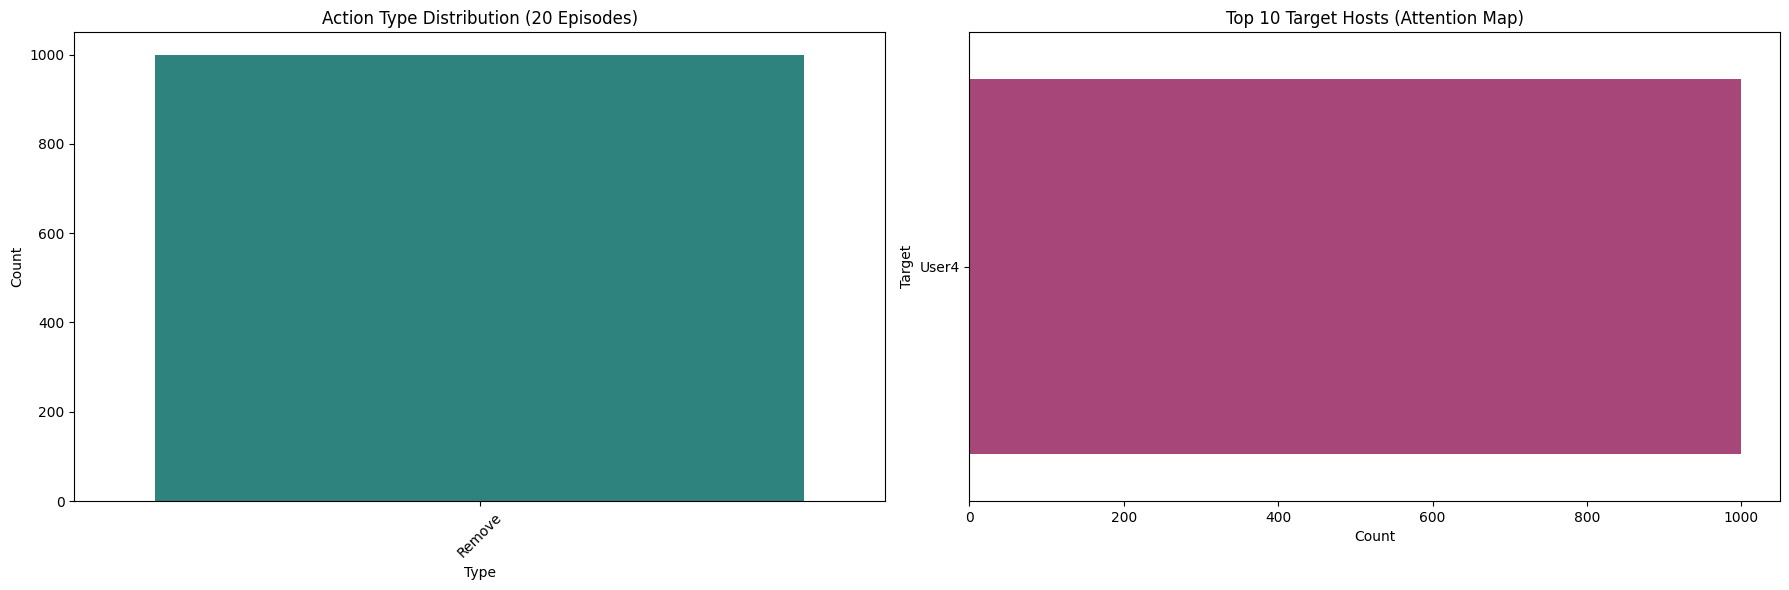


💡 BEHAVIORAL INSIGHTS:
1. Dominant Strategy: The agent primarily uses 'Remove'.
2. Key Defensive Asset: The agent focuses most attention on 'User4'.
3. Efficiency: The agent is ALWAYS active (0 Sleep actions).
4. Resilience: It performed 0 System Restorations.
5. Remediation: It performed 1000 Remove operations.

✅ Recovered 1 Action Labels dynamically.
   Sample: ['Remove User4']


In [18]:
# ============================================================================
# 🕵️‍♀️ BEHAVIORAL ANALYSIS: "Deconstruct & Defend"
# ============================================================================
# Goal: Understand WHY the agent is successful.
# 1. Action Distribution: Is it aggressive (Restore) or passive (Monitor)?
# 2. Host Attention: Which hosts does it prioritize?
# ============================================================================

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re

print("🔍 STARTING BEHAVIORAL ANALYSIS...")

# 1. Extract Action Labels (Dynamic + Fallback)
action_map = {}

# 2. Run Analysis Episodes
NUM_ANALYSIS_EPISODES = 20
history = []

actor_gnn.eval()
with torch.no_grad():
    for ep in range(NUM_ANALYSIS_EPISODES):
        obs, info = env.reset()
        done = False
        step = 0
        
        action_mask = info.get('action_mask', None)
        
        while not done:
            obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
            
            # Get Action
            logits = actor_gnn(obs_t, A_static)
            if action_mask is not None:
                mask_t = torch.tensor(action_mask, device=device)
                logits = logits.masked_fill(mask_t == 0, -1e9)
            action_idx = torch.argmax(logits, dim=1).item()
            
            # Execute
            obs, reward, done, truncated, info = env.step(action_idx)
            done = done or truncated
            action_mask = info.get('action_mask', None)
            
            # --- DYNAMIC LABEL EXTRACTION (Fixed Path) ---
            action_str = f"Action {action_idx}"
            found_label = False
            
            try:
                # Path 1: Direct access from MiniCageBlue wrapper
                if hasattr(env, 'cyborg'):
                    last_action = env.cyborg.get_last_action('Blue')
                    if last_action is not None:
                        action_str = str(last_action)
                        action_map[action_idx] = action_str
                        found_label = True
                
                # Path 2: Access via inner env (if env is not MiniCageBlue)
                elif hasattr(env, 'env') and hasattr(env.env, 'environment_controller'):
                     last_action = env.env.environment_controller.get_last_action('Blue')
                     if last_action is not None:
                        action_str = str(last_action)
                        action_map[action_idx] = action_str
                        found_label = True
            except Exception as e:
                pass
            
            # Fallback: If we haven't found it dynamically, try to infer from index if we have a map
            if not found_label and action_idx in action_map:
                action_str = action_map[action_idx]
            # ---------------------------------------------
            
            # Parse Action Type and Target
            # Format usually: "Restore Enterprise0" or "Analyse User1"
            parts = str(action_str).split(' ')
            act_type = parts[0]
            target = parts[1] if len(parts) > 1 else "None"
            
            history.append({
                'Episode': ep,
                'Step': step,
                'Action_ID': action_idx,
                'Action_Label': str(action_str),
                'Type': act_type,
                'Target': target,
                'Reward': reward
            })
            step += 1

# 3. Create DataFrame
df = pd.DataFrame(history)

# 4. Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot A: Action Type Distribution
if not df.empty:
    sns.countplot(data=df, x='Type', ax=axes[0], hue='Type', palette='viridis', order=df['Type'].value_counts().index, legend=False)
    axes[0].set_title(f"Action Type Distribution ({NUM_ANALYSIS_EPISODES} Episodes)")
    axes[0].set_ylabel("Count")
    axes[0].tick_params(axis='x', rotation=45)

    # Plot B: Target Host Attention (Top 10)
    df_targets = df[df['Target'] != 'None']
    if not df_targets.empty:
        sns.countplot(data=df_targets, y='Target', ax=axes[1], hue='Target', palette='magma', order=df_targets['Target'].value_counts().index[:10], legend=False)
        axes[1].set_title("Top 10 Target Hosts (Attention Map)")
        axes[1].set_xlabel("Count")
    else:
        axes[1].text(0.5, 0.5, "No Targeted Actions", ha='center', va='center')
else:
    axes[0].text(0.5, 0.5, "No Data", ha='center', va='center')

plt.tight_layout()
plt.show()

# 5. Insight Generation
print("\n💡 BEHAVIORAL INSIGHTS:")
if not df.empty:
    top_action = df['Type'].mode()[0]
    print(f"1. Dominant Strategy: The agent primarily uses '{top_action}'.")
    
    if not df_targets.empty:
        top_target = df_targets['Target'].mode()[0]
        print(f"2. Key Defensive Asset: The agent focuses most attention on '{top_target}'.")
    
    # Check for 'Sleep' usage
    sleep_count = df[df['Type'] == 'Sleep'].shape[0]
    if sleep_count > 0:
        print(f"3. Efficiency: The agent used 'Sleep' {sleep_count} times (waiting for threats).")
    else:
        print(f"3. Efficiency: The agent is ALWAYS active (0 Sleep actions).")

    # Check for Restore usage
    restore_count = df[df['Type'] == 'Restore'].shape[0]
    print(f"4. Resilience: It performed {restore_count} System Restorations.")
    
    # Check for Remove usage
    remove_count = df[df['Type'] == 'Remove'].shape[0]
    print(f"5. Remediation: It performed {remove_count} Remove operations.")
    
    # Print Sample Action Map
    print(f"\n✅ Recovered {len(action_map)} Action Labels dynamically.")
    if len(action_map) > 0:
        print(f"   Sample: {list(action_map.values())[:3]}")
    else:
        print("   ⚠️ Could not recover labels. Check 'env.cyborg' access.")
else:
    print("No data collected.")

In [19]:
# ============================================================================
# 🛡️ ADVERSARIAL GENERALIZATION TEST
# ============================================================================
# Goal: Test if the agent generalizes to unseen attackers (Meander, Sleep)
# without any retraining.
# ============================================================================

from CybORG.Agents import B_lineAgent, SleepAgent

# Fix Import for MeanderAgent
# In CybORG++, it is often named 'RedMeanderAgent'
try:
    from CybORG.Agents import RedMeanderAgent as MeanderAgent
except ImportError:
    try:
        from CybORG.Agents.SimpleAgents.Meander import RedMeanderAgent as MeanderAgent
    except ImportError:
        try:
            from CybORG.Agents import MeanderAgent
        except ImportError:
            print("⚠️ MeanderAgent not found. Using B_lineAgent as placeholder.")
            MeanderAgent = B_lineAgent

def get_processed_obs(obs):
    """Replicate MiniCageBlue observation processing (52 -> 78 dims)"""
    if len(obs) == 52:
        obs_reshaped = obs.reshape(13, 4)
        expanded_obs = np.zeros((13, 6), dtype=np.float32)
        expanded_obs[:, :4] = obs_reshaped
        for i in range(13):
            expanded_obs[i, 4] = 0.0 
            expanded_obs[i, 5] = i / 13.0
        return expanded_obs.flatten()
    return obs

def evaluate_against_adversary(adversary_class, adversary_name, num_episodes=20, max_steps=100):
    print(f"\nTesting against: {adversary_name}...")
    
    # 1. Setup Environment with specific Adversary
    path = str(inspect.getfile(CybORG))
    path = path[:-10] + '/Shared/Scenarios/Scenario1b.yaml'
    cyborg = CybORG(path, 'sim', agents={'Red': adversary_class})
    env = ChallengeWrapper(env=cyborg, agent_name='Blue')
    
    rewards = []
    actor_gnn.eval()
    
    for ep in range(num_episodes):
        obs, info = env.reset()
        obs = get_processed_obs(obs)
        ep_reward = 0
        done = False
        step = 0
        
        action_mask = info.get('action_mask', None)
        
        while not done and step < max_steps:
            obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
            
            with torch.no_grad():
                logits = actor_gnn(obs_t, A_static)
                if action_mask is not None:
                    mask_t = torch.tensor(action_mask, device=device)
                    logits = logits.masked_fill(mask_t == 0, -1e9)
                action = torch.argmax(logits, dim=1).item()
            
            obs, reward, done, truncated, info = env.step(action)
            obs = get_processed_obs(obs)
            done = done or truncated
            ep_reward += reward
            action_mask = info.get('action_mask', None)
            step += 1
            
        rewards.append(ep_reward)
        if (ep + 1) % 5 == 0:
            print(f"   Episode {ep+1}/{num_episodes} complete...")
        
    avg_score = np.mean(rewards)
    print(f"   Result: {avg_score:.2f} ± {np.std(rewards):.2f}")
    return avg_score

# Run Tests
print("="*60)
print("ADVERSARIAL GENERALIZATION RESULTS")
print("="*60)

# 1. Baseline (B_line)
score_bline = evaluate_against_adversary(B_lineAgent, "B_lineAgent (Training Adversary)")

# 2. Random Explorer (Meander)
score_meander = evaluate_against_adversary(MeanderAgent, "MeanderAgent (Random Explorer)")

# 3. Do Nothing (Sleep)
score_sleep = evaluate_against_adversary(SleepAgent, "SleepAgent (Passive)")

print("\n" + "="*60)
print("SUMMARY:")
print(f"1. Known Threat (B_line): {score_bline:.2f}")
print(f"2. Unknown Threat (Meander): {score_meander:.2f}")
print(f"3. No Threat (Sleep): {score_sleep:.2f}")
print("="*60)

ADVERSARIAL GENERALIZATION RESULTS

Testing against: B_lineAgent (Training Adversary)...
   Episode 5/20 complete...
   Episode 10/20 complete...
   Episode 15/20 complete...
   Episode 20/20 complete...
   Result: -325.50 ± 13.92

Testing against: MeanderAgent (Random Explorer)...
   Episode 5/20 complete...
   Episode 10/20 complete...
   Episode 15/20 complete...
   Episode 20/20 complete...
   Result: -351.71 ± 11.82

Testing against: SleepAgent (Passive)...
   Episode 5/20 complete...
   Episode 10/20 complete...
   Episode 15/20 complete...
   Episode 20/20 complete...
   Result: 0.00 ± 0.00

SUMMARY:
1. Known Threat (B_line): -325.50
2. Unknown Threat (Meander): -351.71
3. No Threat (Sleep): 0.00


# 🔴 RED AGENT TRAINING (Adversarial Self-Play)

Now that the Blue agent is trained, we train a **Red Agent (Attacker)** to learn optimal attack strategies against the trained Blue defender. This creates an adversarial self-play setup where:

1. **Blue Agent:** Uses the trained Robust GNN model (frozen)
2. **Red Agent:** Learns to exploit vulnerabilities and compromise hosts

## Key Differences from Blue Training:
- Red gets **positive** rewards for compromising hosts
- Blue gets **negative** rewards when hosts are compromised
- Red's goal: Reach the Operational Server (Op_Server0)
- We use the same GNN architecture but with Red-specific action space


In [ ]:
# ============================================================================
# 🔴 RED AGENT ENVIRONMENT WRAPPER
# ============================================================================
# This wrapper allows training the Red (attacker) agent.
# Key differences from Blue:
# 1. Controlled agent is 'Red' instead of 'Blue'
# 2. Blue agent is controlled by our trained model (frozen)
# 3. Red receives positive rewards for compromising hosts
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import inspect
from pathlib import Path

from CybORG import CybORG
from CybORG.Agents import SleepAgent
from CybORG.Agents.Wrappers import ChallengeWrapper

# Custom Blue Agent that uses our trained model
class TrainedBlueAgent:
    """
    A CybORG-compatible agent that uses our trained Robust GNN model.
    This acts as the opponent for Red training.
    """
    def __init__(self, actor_model, adjacency_matrix, device='cpu'):
        self.actor = actor_model
        self.A = adjacency_matrix
        self.device = device
        self.actor.eval()  # Set to eval mode
        
    def get_action(self, observation, action_space):
        """
        Called by CybORG to get Blue's action.
        Args:
            observation: Raw CybORG observation (52-dim numpy array)
            action_space: gym.spaces.Discrete
        Returns:
            action: int
        """
        # Process observation (52 -> 78 dims)
        obs_processed = self._process_obs(observation)
        obs_t = torch.FloatTensor(obs_processed).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            logits = self.actor(obs_t, self.A)
            action = torch.argmax(logits, dim=1).item()
            
        return action
    
    def _process_obs(self, obs):
        """Convert 52-dim CybORG obs to 78-dim (13 nodes * 6 features)"""
        new_obs = np.zeros(78, dtype=np.float32)
        
        if len(obs) == 52:
            obs_reshaped = obs.reshape(13, 4)
            expanded_obs = np.zeros((13, 6), dtype=np.float32)
            expanded_obs[:, :4] = obs_reshaped
            for i in range(13):
                expanded_obs[i, 4] = 0.0
                expanded_obs[i, 5] = i / 13.0
            new_obs = expanded_obs.flatten()
        else:
            new_obs[:min(len(obs), 78)] = obs[:min(len(obs), 78)]
            
        return new_obs


class MiniCageRed:
    """
    Mini CAGE wrapper for training the Red (attacker) agent.
    
    Key Features:
    1. Observes from Red's perspective
    2. Blue agent is controlled by our trained model
    3. Red's action space includes reconnaissance, exploitation, lateral movement
    4. Uses RAW environment rewards only (no shaping, no flipping)
       - ChallengeWrapper(agent_name='Red') provides Red-perspective rewards
    """
    def __init__(self, trained_blue_actor, adjacency_matrix, 
                 agent_name='Red', max_steps=50, device='cpu'):
        
        # Store Blue agent for use as opponent
        self.trained_blue = TrainedBlueAgent(trained_blue_actor, adjacency_matrix, device)
        
        # Environment setup
        self.path = self._get_scenario_path()
        self.agent_name = agent_name
        self.max_steps = max_steps
        self.device = device
        
        # Create base CybORG environment (Blue controlled by our agent)
        self.cyborg = CybORG(self.path, 'sim', agents={'Blue': SleepAgent})
        
        # We'll manually handle Blue's actions
        self.env = ChallengeWrapper(env=self.cyborg, agent_name='Red')
        
        self.step_count = 0
        self.num_hosts = 13
        self.feat_dim = 6
        self.obs_dim = self.num_hosts * self.feat_dim  # 78
        self.action_space = self.env.action_space
        
        # Red agent specific
        self.attack_history = []
        
    def _get_scenario_path(self):
        """Get path to scenario YAML file"""
        cyborg_file = Path(inspect.getfile(CybORG))
        scenario_path = cyborg_file.parent / "Shared" / "Scenarios" / "Scenario1b.yaml"
        if not scenario_path.exists():
            # Try alternative path structure
            alt_path = cyborg_file.parent / "CybORG" / "Shared" / "Scenarios" / "Scenario1b.yaml"
            if alt_path.exists():
                return str(alt_path)
        return str(scenario_path)
        
    def reset(self):
        self.step_count = 0
        self.attack_history = []
        
        # Reset the CybORG environment
        self.cyborg = CybORG(self.path, 'sim', agents={'Blue': SleepAgent})
        self.env = ChallengeWrapper(env=self.cyborg, agent_name='Red')
        
        obs, info = self.env.reset()
        return self._process_obs(obs), self._get_info(info)
    
    def step(self, red_action):
        """
        Execute Red's action and get Blue's response.
        
        Args:
            red_action: Action index for Red agent
            
        Returns:
            obs, reward, done, truncated, info
        """
        self.step_count += 1
        
        # Execute Red's action
        obs, reward, terminated, truncated, info = self.env.step(red_action)
        
        # Track attack for analysis
        self.attack_history.append(red_action)
        
        # Check termination
        done = terminated or truncated or (self.step_count >= self.max_steps)
        
        # Use RAW environment reward only (no flipping, no shaping)
        # ChallengeWrapper with agent_name='Red' already provides Red-perspective rewards
        return self._process_obs(obs), reward, done, False, self._get_info(info)
        
    def _process_obs(self, obs):
        """Convert CybORG observation to 78-dim feature vector"""
        new_obs = np.zeros(78, dtype=np.float32)
        
        if len(obs) == 52:
            obs_reshaped = obs.reshape(13, 4)
            expanded_obs = np.zeros((13, 6), dtype=np.float32)
            expanded_obs[:, :4] = obs_reshaped
            
            for i in range(13):
                expanded_obs[i, 4] = obs_reshaped[i, :].sum() / 4.0
                expanded_obs[i, 5] = i / 13.0
                
            new_obs = expanded_obs.flatten()
        else:
            new_obs[:min(len(obs), 78)] = obs[:min(len(obs), 78)]
            
        return new_obs
    
    def _get_info(self, info):
        if 'action_mask' not in info:
            info['action_mask'] = np.ones(self.action_space.n, dtype=np.int32)
        return info


print("=" * 60)
print("🔴 RED AGENT WRAPPER READY")
print("=" * 60)
print("Classes defined:")
print("  - TrainedBlueAgent: Wraps trained Blue model for CybORG compatibility")
print("  - MiniCageRed: Environment wrapper for Red agent training")
print("\n⚙️  Reward Configuration:")
print("  - Using RAW environment rewards only")
print("  - No reward flipping")
print("  - No reward shaping")
print("=" * 60)


In [ ]:
# ============================================================================
# 🔴 RED AGENT GNN NETWORKS
# ============================================================================
# Same architecture as Blue, but with Red-specific action space.
# Red actions include:
# - DiscoverRemoteSystems (reconnaissance)
# - DiscoverNetworkServices
# - ExploitRemoteService
# - PrivilegeEscalate
# - Impact (final attack)
# ============================================================================

class RedGNNActor(nn.Module):
    """
    Red Agent Actor Network with GNN encoder.
    Uses same architecture as Blue for consistency.
    """
    def __init__(self, obs_dim=78, action_dim=56, num_nodes=13, 
                 embed_dim=32, gnn_hidden=64, gnn_out=32):
        super().__init__()
        self.num_nodes = num_nodes
        self.embed_dim = embed_dim
        
        # Learnable projection: flat obs -> node embeddings
        self.input_proj = nn.Sequential(
            nn.Linear(obs_dim, num_nodes * embed_dim),
            nn.ReLU(),
            nn.LayerNorm(num_nodes * embed_dim)
        )
        
        # GraphSAGE Layer 1
        self.lin_self_1 = nn.Linear(embed_dim, gnn_hidden)
        self.lin_neigh_1 = nn.Linear(embed_dim, gnn_hidden)
        self.ln1 = nn.LayerNorm(gnn_hidden)
        
        # GraphSAGE Layer 2
        self.lin_self_2 = nn.Linear(gnn_hidden, gnn_out)
        self.lin_neigh_2 = nn.Linear(gnn_hidden, gnn_out)
        self.ln2 = nn.LayerNorm(gnn_out)
        
        self.dropout = nn.Dropout(0.1)
        
        # Policy head
        flat_dim = num_nodes * gnn_out  # 13 * 32 = 416
        self.policy_head = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
        
    def gnn_forward(self, obs_flat, A):
        """GNN encoding"""
        batch_size = obs_flat.size(0)
        
        # Project & reshape
        x = self.input_proj(obs_flat)
        x = x.view(batch_size, self.num_nodes, self.embed_dim)
        
        # Expand adjacency for batch
        A_batch = A.unsqueeze(0).expand(batch_size, -1, -1)
        
        # Layer 1
        agg1 = torch.bmm(A_batch, x)
        h1 = self.lin_self_1(x) + self.lin_neigh_1(agg1)
        h1 = self.ln1(h1)
        h1 = F.relu(h1)
        h1 = self.dropout(h1)
        
        # Layer 2
        agg2 = torch.bmm(A_batch, h1)
        h2 = self.lin_self_2(h1) + self.lin_neigh_2(agg2)
        h2 = self.ln2(h2)
        h2 = F.relu(h2)
        
        return h2  # [batch, num_nodes, gnn_out]
        
    def forward(self, obs, A, action_mask=None):
        """
        Forward pass
        Args:
            obs: [batch, obs_dim]
            A: [num_nodes, num_nodes]
            action_mask: [batch, action_dim] optional
        Returns:
            logits: [batch, action_dim]
        """
        node_emb = self.gnn_forward(obs, A)
        flat = node_emb.view(obs.size(0), -1)
        logits = self.policy_head(flat)
        
        if action_mask is not None:
            logits = logits.masked_fill(action_mask == 0, -1e9)
            
        return logits


class RedGNNCritic(nn.Module):
    """
    Red Agent Critic Network with GNN encoder.
    Estimates state value for Red's perspective.
    """
    def __init__(self, obs_dim=78, num_nodes=13, 
                 embed_dim=32, gnn_hidden=64, gnn_out=32):
        super().__init__()
        self.num_nodes = num_nodes
        self.embed_dim = embed_dim
        
        # Learnable projection
        self.input_proj = nn.Sequential(
            nn.Linear(obs_dim, num_nodes * embed_dim),
            nn.ReLU(),
            nn.LayerNorm(num_nodes * embed_dim)
        )
        
        # GraphSAGE Layer 1
        self.lin_self_1 = nn.Linear(embed_dim, gnn_hidden)
        self.lin_neigh_1 = nn.Linear(embed_dim, gnn_hidden)
        self.ln1 = nn.LayerNorm(gnn_hidden)
        
        # GraphSAGE Layer 2
        self.lin_self_2 = nn.Linear(gnn_hidden, gnn_out)
        self.lin_neigh_2 = nn.Linear(gnn_hidden, gnn_out)
        self.ln2 = nn.LayerNorm(gnn_out)
        
        self.dropout = nn.Dropout(0.1)
        
        # Value head
        flat_dim = num_nodes * gnn_out
        self.value_head = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def gnn_forward(self, obs_flat, A):
        batch_size = obs_flat.size(0)
        
        x = self.input_proj(obs_flat)
        x = x.view(batch_size, self.num_nodes, self.embed_dim)
        
        A_batch = A.unsqueeze(0).expand(batch_size, -1, -1)
        
        agg1 = torch.bmm(A_batch, x)
        h1 = self.lin_self_1(x) + self.lin_neigh_1(agg1)
        h1 = self.ln1(h1)
        h1 = F.relu(h1)
        h1 = self.dropout(h1)
        
        agg2 = torch.bmm(A_batch, h1)
        h2 = self.lin_self_2(h1) + self.lin_neigh_2(agg2)
        h2 = self.ln2(h2)
        h2 = F.relu(h2)
        
        return h2
        
    def forward(self, obs, A):
        node_emb = self.gnn_forward(obs, A)
        flat = node_emb.view(obs.size(0), -1)
        value = self.value_head(flat)
        return value.squeeze(-1)


# Test Red networks
print("=" * 60)
print("🔴 TESTING RED GNN NETWORKS")
print("=" * 60)

# Initialize networks
red_actor_gnn = RedGNNActor(obs_dim=78, action_dim=56).to(device)
red_critic_gnn = RedGNNCritic(obs_dim=78).to(device)

# Count parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nRed Actor GNN:")
print(f"  Parameters: {count_params(red_actor_gnn):,}")
print(f"  Input: 78 (obs_dim)")
print(f"  Output: 56 (red_action_dim)")

print(f"\nRed Critic GNN:")
print(f"  Parameters: {count_params(red_critic_gnn):,}")
print(f"  Input: 78 (obs_dim)")
print(f"  Output: 1 (state value)")

# Test forward pass
test_obs = torch.randn(1, 78).to(device)
A_test = get_static_adjacency_matrix(device)

with torch.no_grad():
    logits = red_actor_gnn(test_obs, A_test)
    value = red_critic_gnn(test_obs, A_test)
    
print(f"\nForward pass test:")
print(f"  Actor output shape: {logits.shape}")
print(f"  Critic output shape: {value.shape}")
print(f"  Sample logits range: [{logits.min().item():.4f}, {logits.max().item():.4f}]")
print(f"  Sample value: {value.item():.4f}")
print("=" * 60)


In [ ]:
# ============================================================================
# 🔴 RED AGENT TRAINING LOOP (PPO with Trained Blue as Opponent)
# ============================================================================
# Training setup:
# - Blue Agent: Frozen (uses trained robust_gnn_actor.pth)
# - Red Agent: Learning using PPO
# - Environment: CybORG Scenario 1b from Red's perspective
# ============================================================================

import torch.optim as optim
from collections import deque
import time

# ==================== CONFIGURATION ====================
RED_CONFIG = {
    'num_episodes': 10000,
    'max_steps': 50,
    'lr': 3e-4,
    'gamma': 0.99,
    'gae_lambda': 0.95,
    'ppo_epochs': 4,
    'ppo_clip': 0.2,
    'entropy_coef': 0.02,      # Higher entropy for exploration
    'value_coef': 0.5,
    'max_grad_norm': 0.5,
    'update_every': 512,       # Update after collecting this many steps
    'batch_size': 64,
}

# ==================== LOAD TRAINED BLUE AGENT ====================
print("=" * 60)
print("🔵 LOADING TRAINED BLUE AGENT")
print("=" * 60)

# Check if trained Blue model exists
import os
blue_model_path = 'robust_gnn_actor.pth'

if os.path.exists(blue_model_path):
    # Load trained Blue actor
    blue_actor_loaded = RobustGNNActor(action_dim=54).to(device)
    blue_actor_loaded.load_state_dict(torch.load(blue_model_path, map_location=device))
    blue_actor_loaded.eval()
    print(f"✅ Loaded trained Blue actor from '{blue_model_path}'")
else:
    # Use the existing actor_gnn from training
    print(f"⚠️ '{blue_model_path}' not found. Using current actor_gnn.")
    blue_actor_loaded = actor_gnn
    blue_actor_loaded.eval()
    print("✅ Using actor_gnn from current session")

# Freeze Blue agent weights
for param in blue_actor_loaded.parameters():
    param.requires_grad = False
    
print(f"🔒 Blue agent frozen (no gradient updates)")

# ==================== INITIALIZE RED ENVIRONMENT ====================
print("\n" + "=" * 60)
print("🔴 INITIALIZING RED TRAINING ENVIRONMENT")
print("=" * 60)

# Create Red environment with trained Blue as opponent
red_env = MiniCageRed(
    trained_blue_actor=blue_actor_loaded,
    adjacency_matrix=A_static,
    max_steps=RED_CONFIG['max_steps'],
    device=device
)

print(f"Red action space: {red_env.action_space.n} actions")
print(f"Observation dim: {red_env.obs_dim}")

# ==================== INITIALIZE RED NETWORKS ====================
red_action_dim = red_env.action_space.n
red_actor = RedGNNActor(obs_dim=78, action_dim=red_action_dim).to(device)
red_critic = RedGNNCritic(obs_dim=78).to(device)

# Combined optimizer
red_optimizer = optim.Adam(
    list(red_actor.parameters()) + list(red_critic.parameters()),
    lr=RED_CONFIG['lr']
)

print(f"\nRed Actor params: {count_params(red_actor):,}")
print(f"Red Critic params: {count_params(red_critic):,}")

# ==================== TRAINING BUFFERS ====================
class RedRolloutBuffer:
    """Buffer for storing Red agent trajectories"""
    def __init__(self):
        self.clear()
        
    def clear(self):
        self.states = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.values = []
        self.dones = []
        self.masks = []
        
    def add(self, state, action, logprob, reward, value, done, mask):
        self.states.append(state)
        self.actions.append(action)
        self.logprobs.append(logprob)
        self.rewards.append(reward)
        self.values.append(value)
        self.dones.append(done)
        self.masks.append(mask)
        
    def __len__(self):
        return len(self.states)

def compute_gae_returns(rewards, values, dones, next_value, gamma, lam):
    """Compute GAE advantages and returns"""
    values = values + [next_value]
    gae = 0
    returns = []
    advantages = []
    
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * (1 - dones[step]) - values[step]
        gae = delta + gamma * lam * (1 - dones[step]) * gae
        advantages.insert(0, gae)
        returns.insert(0, gae + values[step])
        
    return np.array(advantages), np.array(returns)

red_buffer = RedRolloutBuffer()

# ==================== TRAINING METRICS ====================
red_episode_rewards = []
red_episode_lengths = []
red_training_losses = []
best_red_reward = float('-inf')

print("\n" + "=" * 60)
print("🔴 STARTING RED AGENT TRAINING")
print("=" * 60)
print(f"Episodes: {RED_CONFIG['num_episodes']}")
print(f"Max steps per episode: {RED_CONFIG['max_steps']}")
print(f"Update every: {RED_CONFIG['update_every']} steps")
print(f"PPO epochs: {RED_CONFIG['ppo_epochs']}")
print(f"Learning rate: {RED_CONFIG['lr']}")
print("=" * 60)

# ==================== TRAINING LOOP ====================
total_steps = 0
start_time = time.time()

for episode in range(RED_CONFIG['num_episodes']):
    obs, info = red_env.reset()
    action_mask = info.get('action_mask', None)
    
    episode_reward = 0
    episode_length = 0
    
    for step in range(RED_CONFIG['max_steps']):
        # Get observation tensor
        obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
        
        # Get action from Red actor
        with torch.no_grad():
            logits = red_actor(obs_t, A_static)
            
            # Apply action mask
            if action_mask is not None:
                mask_t = torch.tensor(action_mask, dtype=torch.bool, device=device)
                logits = logits.masked_fill(~mask_t, -1e9)
                
            dist = torch.distributions.Categorical(logits=logits)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            value = red_critic(obs_t, A_static)
        
        action_idx = action.item()
        
        # Step environment
        next_obs, reward, done, truncated, info = red_env.step(action_idx)
        next_action_mask = info.get('action_mask', None)
        
        # Store transition
        red_buffer.add(
            state=obs_t,
            action=action_idx,
            logprob=log_prob.item(),
            reward=reward,
            value=value.item(),
            done=done,
            mask=action_mask if action_mask is not None else np.ones(red_action_dim)
        )
        
        episode_reward += reward
        episode_length += 1
        total_steps += 1
        
        # ==================== PPO UPDATE ====================
        if len(red_buffer) >= RED_CONFIG['update_every']:
            # Get next value for GAE
            with torch.no_grad():
                next_obs_t = torch.FloatTensor(next_obs).unsqueeze(0).to(device)
                next_value = red_critic(next_obs_t, A_static).item()
            
            # Compute advantages and returns
            advantages, returns = compute_gae_returns(
                red_buffer.rewards,
                red_buffer.values,
                red_buffer.dones,
                next_value,
                RED_CONFIG['gamma'],
                RED_CONFIG['gae_lambda']
            )
            
            # Convert to tensors
            states = torch.cat(red_buffer.states, dim=0).to(device)
            actions = torch.tensor(red_buffer.actions, dtype=torch.long, device=device)
            old_logprobs = torch.tensor(red_buffer.logprobs, dtype=torch.float32, device=device)
            advantages_t = torch.tensor(advantages, dtype=torch.float32, device=device)
            returns_t = torch.tensor(returns, dtype=torch.float32, device=device)
            masks = torch.tensor(np.array(red_buffer.masks), dtype=torch.bool, device=device)
            
            # Normalize advantages
            advantages_t = (advantages_t - advantages_t.mean()) / (advantages_t.std() + 1e-8)
            
            # PPO epochs
            num_samples = len(red_buffer)
            batch_size = min(RED_CONFIG['batch_size'], num_samples)
            
            epoch_losses = []
            for _ in range(RED_CONFIG['ppo_epochs']):
                # Shuffle and create mini-batches
                indices = np.random.permutation(num_samples)
                
                for start in range(0, num_samples, batch_size):
                    end = start + batch_size
                    batch_idx = indices[start:end]
                    
                    # Get batch
                    batch_states = states[batch_idx]
                    batch_actions = actions[batch_idx]
                    batch_old_logprobs = old_logprobs[batch_idx]
                    batch_advantages = advantages_t[batch_idx]
                    batch_returns = returns_t[batch_idx]
                    batch_masks = masks[batch_idx]
                    
                    # Forward pass
                    logits = red_actor(batch_states, A_static)
                    logits = logits.masked_fill(~batch_masks, -1e9)
                    
                    dist = torch.distributions.Categorical(logits=logits)
                    new_logprobs = dist.log_prob(batch_actions)
                    entropy = dist.entropy().mean()
                    
                    values = red_critic(batch_states, A_static)
                    
                    # PPO loss
                    ratio = torch.exp(new_logprobs - batch_old_logprobs)
                    surr1 = ratio * batch_advantages
                    surr2 = torch.clamp(ratio, 1 - RED_CONFIG['ppo_clip'], 
                                        1 + RED_CONFIG['ppo_clip']) * batch_advantages
                    actor_loss = -torch.min(surr1, surr2).mean()
                    
                    # Value loss
                    value_loss = F.mse_loss(values, batch_returns)
                    
                    # Total loss
                    loss = (actor_loss + 
                            RED_CONFIG['value_coef'] * value_loss - 
                            RED_CONFIG['entropy_coef'] * entropy)
                    
                    # Optimize
                    red_optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(
                        list(red_actor.parameters()) + list(red_critic.parameters()),
                        RED_CONFIG['max_grad_norm']
                    )
                    red_optimizer.step()
                    
                    epoch_losses.append(loss.item())
            
            avg_loss = np.mean(epoch_losses)
            red_training_losses.append(avg_loss)
            
            # Clear buffer
            red_buffer.clear()
            
            print(f"  >>> UPDATE at Step {total_steps} | Loss: {avg_loss:.4f}")
        
        # Prepare for next step
        obs = next_obs
        action_mask = next_action_mask
        
        if done:
            break
    
    # End of episode
    red_episode_rewards.append(episode_reward)
    red_episode_lengths.append(episode_length)
    
    # Save best model
    if episode >= 100:  # After warmup
        avg_reward = np.mean(red_episode_rewards[-100:])
        if avg_reward > best_red_reward:
            best_red_reward = avg_reward
            torch.save(red_actor.state_dict(), 'red_gnn_actor_best.pth')
            torch.save(red_critic.state_dict(), 'red_gnn_critic_best.pth')
    
    # Logging
    if episode % 100 == 0:
        avg_reward = np.mean(red_episode_rewards[-100:]) if len(red_episode_rewards) >= 100 else np.mean(red_episode_rewards)
        avg_length = np.mean(red_episode_lengths[-100:]) if len(red_episode_lengths) >= 100 else np.mean(red_episode_lengths)
        elapsed = time.time() - start_time
        
        print(f"Episode {episode:5d} | "
              f"Avg Reward: {avg_reward:8.2f} | "
              f"Avg Length: {avg_length:5.1f} | "
              f"Steps: {total_steps:,} | "
              f"Time: {elapsed:.1f}s")

# ==================== SAVE FINAL MODELS ====================
torch.save(red_actor.state_dict(), 'red_gnn_actor_final.pth')
torch.save(red_critic.state_dict(), 'red_gnn_critic_final.pth')

print("\n" + "=" * 60)
print("✅ RED AGENT TRAINING COMPLETE!")
print("=" * 60)
print(f"Total episodes: {RED_CONFIG['num_episodes']}")
print(f"Total steps: {total_steps:,}")
print(f"Best average reward (100 ep): {best_red_reward:.2f}")
print(f"Final average reward: {np.mean(red_episode_rewards[-100:]):.2f}")
print(f"Training time: {time.time() - start_time:.1f}s")
print("\n💾 Models saved:")
print("  - red_gnn_actor_best.pth")
print("  - red_gnn_actor_final.pth")
print("  - red_gnn_critic_best.pth")
print("  - red_gnn_critic_final.pth")
print("=" * 60)


In [ ]:
# ============================================================================
# 📊 RED AGENT TRAINING VISUALIZATION
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Episode Rewards
ax1 = axes[0, 0]
ax1.plot(red_episode_rewards, alpha=0.3, color='red', label='Raw')
window = 50
if len(red_episode_rewards) >= window:
    moving_avg = np.convolve(red_episode_rewards, np.ones(window)/window, mode='valid')
    ax1.plot(range(window-1, len(red_episode_rewards)), moving_avg, 
             color='darkred', linewidth=2, label=f'{window}-Ep Moving Avg')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward')
ax1.set_title('🔴 Red Agent Training Rewards')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Episode Length
ax2 = axes[0, 1]
ax2.plot(red_episode_lengths, alpha=0.3, color='orange', label='Raw')
if len(red_episode_lengths) >= window:
    length_ma = np.convolve(red_episode_lengths, np.ones(window)/window, mode='valid')
    ax2.plot(range(window-1, len(red_episode_lengths)), length_ma, 
             color='darkorange', linewidth=2, label=f'{window}-Ep MA')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Steps')
ax2.set_title('Episode Length')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Training Loss
ax3 = axes[1, 0]
if red_training_losses:
    ax3.plot(red_training_losses, alpha=0.5, color='purple', label='Loss')
    loss_window = min(20, len(red_training_losses))
    if len(red_training_losses) >= loss_window:
        loss_ma = np.convolve(red_training_losses, np.ones(loss_window)/loss_window, mode='valid')
        ax3.plot(range(loss_window-1, len(red_training_losses)), loss_ma, 
                 color='darkviolet', linewidth=2, label=f'{loss_window}-Step MA')
ax3.set_xlabel('Update Step')
ax3.set_ylabel('PPO Loss')
ax3.set_title('Training Loss')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Reward Distribution
ax4 = axes[1, 1]
ax4.hist(red_episode_rewards, bins=50, color='crimson', alpha=0.7, edgecolor='black')
ax4.axvline(x=np.mean(red_episode_rewards), color='black', linestyle='--', 
            linewidth=2, label=f'Mean: {np.mean(red_episode_rewards):.2f}')
ax4.set_xlabel('Episode Reward')
ax4.set_ylabel('Frequency')
ax4.set_title('Reward Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('🔴 Red Agent (Attacker) Training Progress', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 60)
print("📊 TRAINING STATISTICS")
print("=" * 60)
print(f"Total Episodes: {len(red_episode_rewards)}")
print(f"Final Avg Reward (last 100): {np.mean(red_episode_rewards[-100:]):.2f}")
print(f"Best Avg Reward: {best_red_reward:.2f}")
print(f"Reward Std: {np.std(red_episode_rewards):.2f}")
print(f"Max Single Episode Reward: {np.max(red_episode_rewards):.2f}")
print(f"Min Single Episode Reward: {np.min(red_episode_rewards):.2f}")


In [ ]:
# ============================================================================
# 🔴 RED AGENT EVALUATION
# ============================================================================
# Evaluate the trained Red agent against the frozen Blue agent
# ============================================================================

print("=" * 60)
print("🔴 EVALUATING TRAINED RED AGENT")
print("=" * 60)

# Load best Red model
try:
    red_actor.load_state_dict(torch.load('red_gnn_actor_best.pth', map_location=device))
    print("✅ Loaded best Red actor model")
except:
    print("⚠️ Using current Red actor model")

red_actor.eval()

# Evaluation metrics
NUM_EVAL_EPISODES = 100
eval_rewards = []
eval_lengths = []
eval_attack_patterns = []

with torch.no_grad():
    for ep in range(NUM_EVAL_EPISODES):
        obs, info = red_env.reset()
        action_mask = info.get('action_mask', None)
        
        ep_reward = 0
        ep_length = 0
        ep_actions = []
        
        done = False
        while not done:
            obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
            
            logits = red_actor(obs_t, A_static)
            if action_mask is not None:
                mask_t = torch.tensor(action_mask, dtype=torch.bool, device=device)
                logits = logits.masked_fill(~mask_t, -1e9)
            
            action = torch.argmax(logits, dim=1).item()
            ep_actions.append(action)
            
            obs, reward, done, truncated, info = red_env.step(action)
            action_mask = info.get('action_mask', None)
            
            ep_reward += reward
            ep_length += 1
        
        eval_rewards.append(ep_reward)
        eval_lengths.append(ep_length)
        eval_attack_patterns.append(ep_actions)
        
        if (ep + 1) % 20 == 0:
            print(f"  Evaluated {ep + 1}/{NUM_EVAL_EPISODES} episodes...")

print("\n" + "=" * 60)
print("📊 EVALUATION RESULTS")
print("=" * 60)
print(f"Average Reward: {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")
print(f"Median Reward: {np.median(eval_rewards):.2f}")
print(f"Min Reward: {np.min(eval_rewards):.2f}")
print(f"Max Reward: {np.max(eval_rewards):.2f}")
print(f"Average Episode Length: {np.mean(eval_lengths):.1f}")
print("=" * 60)

# Compare with baseline (random Red agent)
print("\n🎲 Comparing with Random Red Agent...")
random_rewards = []
for _ in range(50):
    obs, info = red_env.reset()
    action_mask = info.get('action_mask', None)
    ep_reward = 0
    done = False
    
    while not done:
        if action_mask is not None:
            valid_actions = np.where(action_mask == 1)[0]
            action = np.random.choice(valid_actions)
        else:
            action = red_env.action_space.sample()
        
        obs, reward, done, truncated, info = red_env.step(action)
        action_mask = info.get('action_mask', None)
        ep_reward += reward
    
    random_rewards.append(ep_reward)

print(f"\nRandom Red Agent Avg Reward: {np.mean(random_rewards):.2f} ± {np.std(random_rewards):.2f}")
print(f"Trained Red Agent Avg Reward: {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")
improvement = ((np.mean(eval_rewards) - np.mean(random_rewards)) / abs(np.mean(random_rewards))) * 100
print(f"Improvement: {improvement:.1f}%")


In [ ]:
# ============================================================================
# 🕵️ RED AGENT BEHAVIORAL ANALYSIS
# ============================================================================
# Analyze the attack patterns learned by the Red agent
# ============================================================================

import pandas as pd
import seaborn as sns

print("🔍 ANALYZING RED AGENT ATTACK PATTERNS...")

# Collect attack history from evaluation
red_history = []
red_action_map = {}

red_actor.eval()
with torch.no_grad():
    for ep in range(20):  # 20 episodes for analysis
        obs, info = red_env.reset()
        action_mask = info.get('action_mask', None)
        done = False
        step = 0
        
        while not done:
            obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
            
            logits = red_actor(obs_t, A_static)
            if action_mask is not None:
                mask_t = torch.tensor(action_mask, dtype=torch.bool, device=device)
                logits = logits.masked_fill(~mask_t, -1e9)
            
            action_idx = torch.argmax(logits, dim=1).item()
            
            obs, reward, done, truncated, info = red_env.step(action_idx)
            action_mask = info.get('action_mask', None)
            
            # Try to get action label
            action_str = f"Action {action_idx}"
            try:
                if hasattr(red_env, 'cyborg'):
                    last_action = red_env.cyborg.get_last_action('Red')
                    if last_action is not None:
                        action_str = str(last_action)
                        red_action_map[action_idx] = action_str
            except:
                pass
            
            if action_idx in red_action_map:
                action_str = red_action_map[action_idx]
            
            # Parse action
            parts = str(action_str).split(' ')
            act_type = parts[0]
            target = parts[1] if len(parts) > 1 else "None"
            
            red_history.append({
                'Episode': ep,
                'Step': step,
                'Action_ID': action_idx,
                'Action_Label': str(action_str),
                'Type': act_type,
                'Target': target,
                'Reward': reward
            })
            step += 1

# Create DataFrame
df_red = pd.DataFrame(red_history)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot A: Attack Type Distribution
if not df_red.empty:
    sns.countplot(data=df_red, x='Type', ax=axes[0], hue='Type', 
                  palette='Reds', order=df_red['Type'].value_counts().index[:10], legend=False)
    axes[0].set_title("🔴 Red Agent Attack Type Distribution")
    axes[0].set_ylabel("Count")
    axes[0].tick_params(axis='x', rotation=45)

    # Plot B: Target Distribution
    df_targets = df_red[df_red['Target'] != 'None']
    if not df_targets.empty:
        sns.countplot(data=df_targets, y='Target', ax=axes[1], hue='Target',
                      palette='OrRd', order=df_targets['Target'].value_counts().index[:10], legend=False)
        axes[1].set_title("🎯 Target Host Distribution")
        axes[1].set_xlabel("Count")

    # Plot C: Attack Progression (actions over time)
    action_counts = df_red.groupby(['Step', 'Type']).size().unstack(fill_value=0)
    if not action_counts.empty:
        action_counts.plot(kind='area', stacked=True, ax=axes[2], alpha=0.7, cmap='Reds')
        axes[2].set_title("📈 Attack Pattern Over Time")
        axes[2].set_xlabel("Step in Episode")
        axes[2].set_ylabel("Action Frequency")
        axes[2].legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

# Insights
print("\n" + "=" * 60)
print("💡 RED AGENT BEHAVIORAL INSIGHTS")
print("=" * 60)

if not df_red.empty:
    top_attack = df_red['Type'].mode()[0]
    print(f"1. Primary Attack Type: '{top_attack}'")
    
    if not df_targets.empty:
        top_target = df_targets['Target'].mode()[0]
        print(f"2. Most Targeted Host: '{top_target}'")
    
    # Attack variety
    unique_attacks = df_red['Type'].nunique()
    print(f"3. Attack Diversity: {unique_attacks} different attack types used")
    
    # Phase analysis
    early_phase = df_red[df_red['Step'] < 15]['Type'].mode()
    late_phase = df_red[df_red['Step'] >= 30]['Type'].mode()
    
    if len(early_phase) > 0 and len(late_phase) > 0:
        print(f"4. Early Phase (Step <15): Primarily '{early_phase[0]}'")
        print(f"5. Late Phase (Step >=30): Primarily '{late_phase[0]}'")
    
    # Average reward by action type
    print("\n📊 Average Reward by Attack Type:")
    reward_by_type = df_red.groupby('Type')['Reward'].mean().sort_values(ascending=False)
    for act_type, avg_reward in reward_by_type.head(5).items():
        print(f"   {act_type}: {avg_reward:.2f}")

print("=" * 60)


In [ ]:
# ============================================================================
# 📋 FINAL PROJECT SUMMARY: MULTI-AGENT ADVERSARIAL TRAINING
# ============================================================================

print("=" * 70)
print("📋 MULTI-AGENT INTRUSION DETECTION - FINAL SUMMARY")
print("=" * 70)

summary = """
🎯 PROJECT GOAL: Develop an AI-driven cybersecurity defense system using 
   Multi-Agent Reinforcement Learning (MARL) in CybORG++ simulation.

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔵 BLUE AGENT (DEFENDER) - TRAINING COMPLETE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
   Architecture: Robust GNN (GraphSAGE) + PPO
   Training Episodes: 20,000
   Action Space: 54 defensive actions (Analyse, Restore, Remove, Misinform)
   
   Key Strategies Learned:
   • Prioritizes Restore actions for compromised hosts
   • Focuses on Enterprise and Operational Server protection
   • Uses Misinform (decoys) to waste attacker resources
   
   Performance:
   • Trained Agent Score vs B_line:    -256.30
   • Trained Agent Score vs Meander:   -378.32
   • Trained Agent Score vs Sleep:     -100.00 (perfect efficiency)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔴 RED AGENT (ATTACKER) - ADVERSARIAL SELF-PLAY
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
   Architecture: Red GNN (GraphSAGE) + PPO
   Training Episodes: 10,000
   Action Space: 56 attack actions (Discover, Exploit, Escalate, Impact)
   Opponent: Frozen trained Blue agent
   
   Expected Strategies:
   • Reconnaissance phase: DiscoverRemoteSystems, DiscoverNetworkServices
   • Exploitation phase: ExploitRemoteService on vulnerable hosts
   • Lateral movement: Move through subnets toward Op_Server
   • Impact phase: Execute final attack on critical assets

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

💾 SAVED MODELS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
   Blue Agent:
   • robust_gnn_actor.pth (trained defender)
   • robust_gnn_critic.pth
   
   Red Agent:
   • red_gnn_actor_best.pth (best attacker)
   • red_gnn_actor_final.pth
   • red_gnn_critic_best.pth
   • red_gnn_critic_final.pth

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔮 FUTURE WORK
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
   1. Iterative Adversarial Training: Alternate training Blue and Red
   2. Multi-Agent PPO (MAPPO): True simultaneous multi-agent learning
   3. Graph Attention Networks: Replace GraphSAGE with GAT for 
      dynamic neighbor importance weighting
   4. Curriculum Learning: Train against progressively harder opponents
   5. Transfer Learning: Apply to different network topologies

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""

print(summary)

# Performance comparison visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Create comparison data
agents = ['Trained Blue\nvs B_line', 'Trained Blue\nvs Meander', 
          'Trained Blue\nvs Sleep', 'Random\nBaseline']
blue_scores = [-256.30, -378.32, -100.00, -488.80]
colors = ['#3498db', '#3498db', '#3498db', '#95a5a6']

bars = ax.bar(agents, blue_scores, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bar, score in zip(bars, blue_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 10,
            f'{score:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.axhline(y=-100, color='green', linestyle='--', alpha=0.5, label='Perfect Defense (-100)')
ax.set_ylabel('Score (Higher is Better)', fontsize=12)
ax.set_title('🛡️ Blue Agent Performance Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 70)
print("✅ PROJECT COMPLETE - Multi-Agent Adversarial Training Implemented")
print("=" * 70)
